<a href="https://colab.research.google.com/github/romqn1999/Predict-price-after-pattern/blob/main/Predict_price_after_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ZM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to ZM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving Z_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to Z_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving Y_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to Y_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving XPEV_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to XPEV_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving XOM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to XOM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving X_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to X_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Saving WMT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv to WMT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Savi

## Import packages

In [3]:
import math
import matplotlib.pyplot as plt
import keras
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras import optimizers
from keras.optimizers import Adagrad, Adadelta, RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Get data at pattern for training & testing

In [4]:
import io
import pandas as pd

price_patterns_df = pd.DataFrame()
for filename in uploaded.keys():
    print(filename)
    if 'double_top_data_patterns.csv' not in filename:
    # if 'data_patterns.csv' not in filename:
        print('Skipping file', filename)
        continue
    df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')),
                     header=None)
    price_patterns_df = price_patterns_df.append(df)

price_patterns_df = price_patterns_df.sample(frac=1).reset_index(drop=True)
price_patterns_df

ZM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Z_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
Y_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
XPEV_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
XOM_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
X_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
WMT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
WFC_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
W_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VZ_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VXRT_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VICI_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
VIAC_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
V_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
TSLA_2000-01-01 00_00_00_2021-06-02_30_double_top_data_patterns.csv
T_

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
0,105.510002,105.040001,104.260002,101.010002,101.199997,102.870003,101.860001,97.110001,98.449997,98.430000,98.650002,96.779999,96.160004,92.050003,92.519997,89.660004,92.010002,88.620003,89.160004,91.690002,99.949997,103.849998,118.419998,104.120003,100.389999,108.019997,107.419998,106.029999,107.040001,105.260002,102.239998
1,68.940002,70.470001,69.989998,71.610001,72.290001,72.750000,71.889999,71.430000,70.720001,70.389999,70.650002,70.599998,70.029999,69.730003,69.470001,69.180000,68.129997,69.110001,68.750000,68.209999,66.550003,66.489998,68.000000,68.589996,69.919998,71.300003,70.680000,71.370003,70.860001,70.120003,69.150002
2,33.820000,32.090000,30.190001,26.760000,28.320000,26.250000,24.450001,26.520000,23.219999,27.170000,25.480000,27.139999,24.920000,22.680000,24.740000,24.030001,25.540001,23.690001,24.240000,24.110001,22.240000,23.020000,21.690001,23.469999,22.910000,24.340000,27.120001,25.059999,24.660000,22.700001,21.610001
3,52.060001,52.520000,52.259998,52.410000,52.310001,52.590000,52.340000,51.779999,52.340000,52.529999,52.919998,52.650002,52.009998,51.830002,52.360001,52.290001,52.599998,53.040001,53.299999,53.040001,53.320000,54.099998,54.330002,54.619999,55.360001,54.639999,54.959999,54.919998,55.369999,54.580002,55.110001
4,61.000000,61.000000,59.000000,59.000000,62.000000,64.000000,60.000000,60.000000,60.000000,58.000000,60.000000,59.000000,61.000000,59.000000,59.000000,59.000000,56.000000,58.000000,56.000000,55.000000,53.000000,52.000000,54.000000,52.000000,53.000000,54.000000,53.000000,52.000000,53.000000,51.000000,54.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5642,155628.000000,161568.000000,159192.000000,162360.000000,158400.000000,158400.000000,163152.000000,162756.000000,168300.000000,176220.000000,170280.000000,162360.000000,197208.000000,179388.000000,186120.000000,186120.000000,183744.000000,184536.000000,171864.000000,178200.000000,174240.000000,173448.000000,169092.000000,175428.000000,168300.000000,177012.000000,178200.000000,170280.000000,167112.000000,154440.000000,144540.000000
5643,7.180000,6.960000,6.860000,6.940000,6.760000,6.990000,6.780000,6.860000,6.760000,7.000000,6.990000,7.040000,6.730000,6.690000,13.610000,14.550000,13.720000,13.580000,14.450000,15.250000,16.370001,15.420000,16.500000,15.020000,14.640000,16.410000,15.600000,15.650000,16.139999,15.590000,15.650000
5644,4803.750000,4620.000000,4620.000000,4620.000000,4593.750000,4462.500000,4357.500000,3911.250000,4173.750000,4095.000000,4042.500000,3937.500000,3753.750000,3753.750000,3832.500000,3937.500000,3780.000000,3806.250000,3675.000000,3543.750000,3517.500000,3412.500000,3333.750000,3307.500000,3123.750000,3123.750000,3386.250000,3333.750000,3386.250000,3281.250000,3360.000000
5645,118.440002,115.919998,119.699997,131.039993,123.480003,118.440002,107.099998,112.139999,110.879997,109.620003,109.620003,100.800003,97.019997,97.019997,94.500000,91.980003,89.459999,88.199997,90.720001,95.760002,89.459999,89.459999,89.459999,88.199997,88.199997,90.720001,88.199997,90.720001,89.459999,88.199997,83.160004


In [5]:
#@title Check if data is nearly formed a line
#@markdown ### Delta price distance from data point to trend line
trend_delta =  15#@param {type:"number"}

# Get angle of vector ba & vector bc
def get_angle(a, b, c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)

    if np.array_equal(a, b) or np.array_equal(a, c) or np.array_equal(b, c):
        return 0

    ba = a - b
    bc = c - b

    if np.all(ba == 0) or np.all(bc == 0):
        return 0

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    # print(a, b, c)
    # print(cosine_angle)
    angle = np.arccos(cosine_angle)

    deg = np.degrees(angle)
    # print('get_angle({}, {}, {}) = {}'.format(a, b, c, deg))
    return deg

def is_trend(x_data, y_data):
    assert len(x_data) == len(y_data)
    if len(x_data) < 2:
        return False
    # print(x_data)
    # print(y_data)
    # Find the line from the first to the last point
    # y = a * x + b
    x1, y1 = x_data[0], y_data[0]
    x2, y2 = x_data[-1], y_data[-1]
    a = (y1 - y2) / (x1 - x2)  # slope
    b = y1 - a * x1  # intercept
    b_is_trend = True
    for i in range(len(x_data)):
        angle1 = get_angle([x_data[0], y_data[0]], [x_data[-1], y_data[-1]], [x_data[i], y_data[i]])
        angle2 = get_angle([x_data[-1], y_data[-1]], [x_data[0], y_data[0]], [x_data[i], y_data[i]])
        if (angle1 > trend_delta) or (angle2 > trend_delta):
            b_is_trend = False
            break
        # y_val = a * x_data[i] + b
        # err = abs(y_val - y_data[i])
        # if (err > trend_delta * y_val):
        #     b_is_trend = False
        #     break
    return b_is_trend
    # p, res, _, _, _ = np.polyfit(x_data, y_data, 1, full=True)
    # err = res[0] if res.size > 0 else 0
    # if err <= len(x_data) * trend_delta:
    #     return True
    # return False

In [6]:
#@markdown ### Delta price distance between 2 tops/bottoms
y_delta = 0.15 #@param {type:"number"}
min_height = 0.5 #@param {type:"number"}

In [7]:
def find_double_top(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max
        # print(key_points)

    suspected_double_tops = list()
    n = len(x_data)
    maxy = np.max(y_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 2):
        for j in range(i + 2, len(key_points)):
            l = key_points[i]
            r = key_points[j]
            # print(l, r, abs(y_data[l] - y_data[r]))
            # if l == 301 and r == 307:
            #     print(y_data[l], y_data[r], max(y_data[key_points[i + 1: j]]))
            if (abs(y_data[l] - y_data[r]) <= y_delta * maxy) \
               and r - l > 1 \
               and min(y_data[l], y_data[r]) >= max(y_data[key_points[i + 1: j]]):
                k_bottom = np.argmin(y_data[l + 1: r]) + l + 1
                # print(l, k_bottom, r)
                if min(y_data[l], y_data[r]) < y_data[k_bottom] + min_height:
                    continue
                (ilows,) = np.where(y_data[:l] <= y_data[k_bottom])
                istart = None
                if ilows.size > 0:
                    istart = ilows[-1]
                (ilows,) = np.where(y_data[r:] <= y_data[k_bottom])
                iend = None
                if ilows.size > 0:
                    iend = ilows[0] + r
                # print(istart, l, k_bottom, r, iend)
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart:l + 1]) \
                   and is_trend(x_data[l: k_bottom + 1], y_data[l: k_bottom + 1]) \
                   and is_trend(x_data[k_bottom: r + 1], y_data[k_bottom: r + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_tops.append((istart, l, k_bottom, r, iend))
    return suspected_double_tops

In [8]:
def find_double_bottom(x_data, y_data, key_points=None):
    assert len(x_data) == len(y_data)
    if key_points is None:        
        #           ___ detection of local minimums and maximums ___
        min_max = np.diff(np.sign(np.diff(y_data))).nonzero()[0] + 1          # local min & max
        l_min = (np.diff(np.sign(np.diff(y_data))) > 0).nonzero()[0] + 1      # local min
        l_max = (np.diff(np.sign(np.diff(y_data))) < 0).nonzero()[0] + 1      # local max
        # +1 due to the fact that diff reduces the original index number
        key_points = min_max

    suspected_double_bottoms = list()
    n = len(x_data)
    maxy = np.max(y_data)
    # for i in range(1, n - 3):
    #     for j in range(i + 2, n - 1):
    for i in range(1, len(key_points) - 2):
        for j in range(i + 2, len(key_points)):
            l = key_points[i]
            r = key_points[j]
            if (abs(y_data[l] - y_data[r]) <= y_delta * maxy) \
               and r - l > 1 \
               and max(y_data[l], y_data[r]) <= min(y_data[key_points[i + 1: j]]):
                k_top = np.argmax(y_data[l + 1: r]) + l + 1
                if max(y_data[l], y_data[r]) + min_height > y_data[k_top]:
                    continue
                (ihights,) = np.where(y_data[:l] >= y_data[k_top])
                istart = None
                if ihights.size > 0:
                    istart = ihights[-1]
                (ihights,) = np.where(y_data[r:] >= y_data[k_top])
                iend = None
                if ihights.size > 0:
                    iend = ihights[0] + r
                if istart and iend \
                   and is_trend(x_data[istart: l + 1], y_data[istart: l + 1]) \
                   and is_trend(x_data[l: k_top + 1], y_data[l: k_top + 1]) \
                   and is_trend(x_data[k_top: r + 1], y_data[k_top: r + 1]) \
                   and is_trend(x_data[r: iend + 1], y_data[r: iend + 1]):                    
                    suspected_double_bottoms.append((istart, l, k_top, r, iend))
    return suspected_double_bottoms

In [9]:
def visualize_res(x_data, y_data, suspected_double_tops, suspected_double_bottoms):
    # ___ plotting ___
    plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
    # plot stock data
    plt.plot(x_data, y_data, '-', markersize=1.5, color='magenta', alpha=0.7)
    plt.axis('equal')

    for istart, top1, bottom, top2, iend in suspected_double_tops:
        plt.plot(x_data[istart], y_data[istart], "o", color='r')
        plt.plot(x_data[top1], y_data[top1], "o", color='b')
        plt.plot(x_data[bottom], y_data[bottom], "o", color='g')
        plt.plot(x_data[top2], y_data[top2], "o", color='b')
        plt.plot(x_data[iend], y_data[iend], "o", color='r')
        plt.plot(np.array(x_data)[[istart, top1, bottom, top2, iend]], np.array(y_data)[[istart, top1, bottom, top2, iend]], "-", color='g')

    for istart, bot1, top, bot2, iend in suspected_double_bottoms:
        plt.plot(np.array(x_data)[[istart, bot1, top, bot2, iend]], np.array(y_data)[[istart, bot1, top, bot2, iend]], "-", color='b')

    plt.show()

In [10]:
i_debug = 1
for i, row in price_patterns_df.iterrows():
    # if i < i_debug: continue
    # if i > i_debug: break
    # x = np.array(range(len(row)))
    # y = row.to_numpy()
    # print(x, y)
    # print(is_trend(x[8:20], y[8:20]))
    double_tops = find_double_top(range(len(row)), row.to_numpy())
    double_bots = find_double_bottom(range(len(row)), row.to_numpy())
    print(i, double_tops, double_bots)
    # visualize_res(range(len(row)), row.to_numpy(), double_tops, double_bots)

0 [(24, 25, 27, 28, 29)] []
1 [(24, 25, 26, 27, 29)] []
2 [(8, 9, 10, 11, 12), (13, 14, 15, 16, 17), (22, 23, 24, 26, 29)] [(4, 6, 7, 8, 9), (12, 13, 14, 15, 16), (19, 20, 21, 22, 23)]
3 [(23, 24, 25, 28, 29)] []
4 [(9, 10, 11, 12, 13), (21, 22, 23, 25, 27), (23, 25, 27, 28, 29)] [(8, 9, 10, 11, 12), (19, 21, 22, 23, 25), (26, 27, 28, 29, 30)]
5 [(4, 5, 7, 10, 13), (19, 20, 21, 22, 23), (24, 25, 26, 28, 29)] [(16, 17, 18, 19, 20)]
6 [(21, 22, 24, 28, 29)] []
7 [(17, 18, 19, 20, 21), (25, 26, 27, 28, 29)] [(23, 25, 26, 27, 28)]
8 [(25, 26, 27, 28, 29)] []
9 [(9, 10, 12, 14, 15), (25, 26, 27, 28, 29)] [(4, 5, 6, 7, 9)]
10 [(5, 8, 9, 11, 15), (24, 25, 26, 28, 29)] [(18, 19, 20, 21, 22)]
11 [(25, 26, 27, 28, 29)] [(14, 16, 18, 19, 20)]
12 [(9, 10, 11, 12, 13), (25, 26, 27, 28, 29)] [(12, 13, 14, 15, 16)]
13 [(21, 24, 26, 27, 29)] []
14 [(5, 7, 8, 9, 10), (24, 25, 26, 27, 29)] []
15 [(24, 25, 26, 28, 29)] []
16 [(23, 24, 26, 27, 29)] [(15, 16, 17, 18, 19)]
17 [(15, 16, 17, 18, 19), (23, 24,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos


Streaming output truncated to the last 5000 lines.
647 [(2, 3, 4, 5, 6), (14, 17, 18, 23, 25), (25, 26, 27, 28, 29)] [(8, 10, 12, 14, 17), (12, 14, 17, 18, 19)]
648 [(2, 3, 4, 5, 6), (23, 24, 25, 27, 29)] [(21, 23, 24, 25, 26)]
649 [(25, 26, 27, 28, 29)] [(13, 14, 15, 18, 19), (24, 25, 26, 27, 28)]
650 [(13, 17, 20, 26, 29)] []
651 [(20, 21, 26, 28, 29)] [(17, 18, 19, 20, 21)]
652 [(3, 6, 7, 8, 9), (17, 20, 21, 28, 29), (24, 25, 26, 28, 29)] []
653 [(25, 26, 27, 28, 29)] []
654 [(14, 19, 23, 27, 29)] []
655 [(16, 18, 24, 27, 29)] []
656 [(20, 21, 22, 24, 29)] []
657 [(9, 10, 11, 12, 13), (23, 24, 25, 27, 29)] [(10, 11, 12, 13, 16), (20, 22, 24, 25, 26)]
658 [(23, 25, 26, 27, 29)] []
659 [(6, 7, 10, 11, 13), (22, 23, 25, 27, 29)] [(21, 22, 23, 25, 27)]
660 [(23, 24, 25, 28, 29)] [(6, 7, 8, 10, 13), (13, 14, 15, 17, 19)]
661 [(24, 25, 26, 27, 29)] [(23, 24, 25, 26, 27)]
662 [(19, 21, 22, 23, 25), (19, 21, 25, 27, 29)] [(21, 22, 23, 25, 26)]
663 [(24, 25, 26, 27, 29)] [(23, 24, 25, 26, 27

In [11]:
#@title Separate into input and output columns: Get data: X and y

X_df = price_patterns_df[price_patterns_df.columns[:-1]]
y_df = price_patterns_df[price_patterns_df.columns[-1:]]
print(X_df)
print(y_df)

X_data = X_df.values
y_data = y_df.values
print(X_data)
print(y_data)

                 0              1   ...             28             29
0        105.510002     105.040001  ...     107.040001     105.260002
1         68.940002      70.470001  ...      70.860001      70.120003
2         33.820000      32.090000  ...      24.660000      22.700001
3         52.060001      52.520000  ...      55.369999      54.580002
4         61.000000      61.000000  ...      53.000000      51.000000
...             ...            ...  ...            ...            ...
5642  155628.000000  161568.000000  ...  167112.000000  154440.000000
5643       7.180000       6.960000  ...      16.139999      15.590000
5644    4803.750000    4620.000000  ...    3386.250000    3281.250000
5645     118.440002     115.919998  ...      89.459999      88.199997
5646     237.600006     229.679993  ...     254.759995     250.139999

[5647 rows x 30 columns]
                 30
0        102.239998
1         69.150002
2         21.610001
3         55.110001
4         54.000000
...           

In [12]:
#@title Preprocess & split data for train model
# Train, test split
train_ratio = 0.8 #@param {type:"number"}
if train_ratio < 0 or  train_ratio > 1:
    train_ratio = 0.8
n_data = len(X_data)
n_train = int(train_ratio * n_data)
n_test = n_data - n_train
# Feature Scaling
scale_method = "MinMax" #@param ["None", "MinMax"]

X_train, y_train = X_data[: n_train], y_data[: n_train]
X_test, y_test = X_data[n_train:], y_data[n_train:]
if scale_method == 'MinMax':
    sc_train = MinMaxScaler(feature_range = (0, 1))
    X_train_scaled = sc_train.fit_transform(X_train.T).T
    y_train_scaled = sc_train.transform(y_train.T).T
    sc_test = MinMaxScaler(feature_range = (0, 1))
    X_test_scaled = sc_test.fit_transform(X_test.T).T
    y_test_scaled = sc_test.transform(y_test.T).T
    # X_train, y_train = X_train_scaled, y_train_scaled
    # X_test, y_test = X_test_scaled, y_test_scaled
print(X_train.shape, y_train.shape)
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test.shape, y_test.shape)
print(X_test_scaled.shape, y_test_scaled.shape)

# print(X_train)
# print(y_train)

(4517, 30) (4517, 1)
(4517, 30) (4517, 1)
(1130, 30) (1130, 1)
(1130, 30) (1130, 1)


## LSTM model

### Build model

In [13]:
#@title Build & fit model
lstm_units = 50 #@param {type:"integer"}
dropout_prob = 0.5 #@param {type:"number"}
epochs = 6000 #@param {type:"integer"}
batch_size = 32768 #@param {type:"integer"}



### Train model

Epoch 1/6000
1/1 [==============================] - 30s 30s/step - loss: 0.2906 - val_loss: 0.2824

Epoch 00001: val_loss improved from inf to 0.28236, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.2457 - val_loss: 0.2395

Epoch 00002: val_loss improved from 0.28236 to 0.23950, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.2042 - val_loss: 0.1985

Epoch 00003: val_loss improved from 0.23950 to 0.19852, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.1661 - val_loss: 0.1702

Epoch 00004: val_loss improved from 0.19852 to 0.17020, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 5/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.1408 - val_loss: 0.1766

Epoch 00005: val_loss did not improve from 0.17020
Epoch 6/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.1505 - val_loss: 0.1843

Epoch 00006: val_loss did not improve from 0.17020
Epoch 7/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.1610 - val_loss: 0.1730

Epoch 00007: val_loss did not improve from 0.17020
Epoch 8/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.1476 - val_loss: 0.1610

Epoch 00008: val_loss improved from 0.17020 to 0.16099, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 9/6000
1/1 [==============================] - 0s 222ms/step - loss: 0.1328 - val_loss: 0.1567

Epoch 00009: val_loss improved from 0.16099 to 0.15670, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 10/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.1269 - val_loss: 0.1581

Epoch 00010: val_loss did not improve from 0.15670
Epoch 11/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.1277 - val_loss: 0.1609

Epoch 00011: val_loss did not improve from 0.15670
Epoch 12/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.1283 - val_loss: 0.1621

Epoch 00012: val_loss did not improve from 0.15670
Epoch 13/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.1296 - val_loss: 0.1609

Epoch 00013: val_loss did not improve from 0.15670
Epoch 14/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.1287 - val_loss: 0.1575

Epoch 00014: val_loss did not improve from 0.15670
Epoch 15/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.1263 - val_loss: 0.1527

Epoch 00015: val_loss improved from 0.15670 to 0.15275, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 16/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.1207 - val_loss: 0.1478

Epoch 00016: val_loss improved from 0.15275 to 0.14784, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 17/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.1177 - val_loss: 0.1440

Epoch 00017: val_loss improved from 0.14784 to 0.14401, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 18/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.1143 - val_loss: 0.1420

Epoch 00018: val_loss improved from 0.14401 to 0.14196, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 19/6000
1/1 [==============================] - 0s 227ms/step - loss: 0.1129 - val_loss: 0.1413

Epoch 00019: val_loss improved from 0.14196 to 0.14127, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 20/6000
1/1 [==============================] - 0s 204ms/step - loss: 0.1135 - val_loss: 0.1405

Epoch 00020: val_loss improved from 0.14127 to 0.14048, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 21/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.1129 - val_loss: 0.1385

Epoch 00021: val_loss improved from 0.14048 to 0.13846, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 22/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.1106 - val_loss: 0.1354

Epoch 00022: val_loss improved from 0.13846 to 0.13537, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 23/6000
1/1 [==============================] - 0s 266ms/step - loss: 0.1076 - val_loss: 0.1324

Epoch 00023: val_loss improved from 0.13537 to 0.13243, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 24/6000
1/1 [==============================] - 0s 203ms/step - loss: 0.1044 - val_loss: 0.1306

Epoch 00024: val_loss improved from 0.13243 to 0.13061, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 25/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.1007 - val_loss: 0.1299

Epoch 00025: val_loss improved from 0.13061 to 0.12985, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 26/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.1018 - val_loss: 0.1294

Epoch 00026: val_loss improved from 0.12985 to 0.12937, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 27/6000
1/1 [==============================] - 0s 205ms/step - loss: 0.0991 - val_loss: 0.1281

Epoch 00027: val_loss improved from 0.12937 to 0.12807, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 28/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0996 - val_loss: 0.1253

Epoch 00028: val_loss improved from 0.12807 to 0.12534, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 29/6000
1/1 [==============================] - 0s 245ms/step - loss: 0.0975 - val_loss: 0.1215

Epoch 00029: val_loss improved from 0.12534 to 0.12149, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 30/6000
1/1 [==============================] - 0s 223ms/step - loss: 0.0940 - val_loss: 0.1175

Epoch 00030: val_loss improved from 0.12149 to 0.11751, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 31/6000
1/1 [==============================] - 0s 205ms/step - loss: 0.0916 - val_loss: 0.1146

Epoch 00031: val_loss improved from 0.11751 to 0.11461, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 32/6000
1/1 [==============================] - 0s 222ms/step - loss: 0.0918 - val_loss: 0.1127

Epoch 00032: val_loss improved from 0.11461 to 0.11268, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 33/6000
1/1 [==============================] - 0s 247ms/step - loss: 0.0892 - val_loss: 0.1106

Epoch 00033: val_loss improved from 0.11268 to 0.11059, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 34/6000
1/1 [==============================] - 0s 204ms/step - loss: 0.0880 - val_loss: 0.1084

Epoch 00034: val_loss improved from 0.11059 to 0.10839, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 35/6000
1/1 [==============================] - 0s 222ms/step - loss: 0.0862 - val_loss: 0.1077

Epoch 00035: val_loss improved from 0.10839 to 0.10769, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 36/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0856 - val_loss: 0.1085

Epoch 00036: val_loss did not improve from 0.10769
Epoch 37/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0862 - val_loss: 0.1084

Epoch 00037: val_loss did not improve from 0.10769
Epoch 38/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0865 - val_loss: 0.1065

Epoch 00038: val_loss improved from 0.10769 to 0.10649, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 39/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0839 - val_loss: 0.1046

Epoch 00039: val_loss improved from 0.10649 to 0.10465, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 40/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0820 - val_loss: 0.1042

Epoch 00040: val_loss improved from 0.10465 to 0.10421, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 41/6000
1/1 [==============================] - 0s 227ms/step - loss: 0.0831 - val_loss: 0.1040

Epoch 00041: val_loss improved from 0.10421 to 0.10405, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 42/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0839 - val_loss: 0.1037

Epoch 00042: val_loss improved from 0.10405 to 0.10367, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 43/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0824 - val_loss: 0.1041

Epoch 00043: val_loss did not improve from 0.10367
Epoch 44/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0802 - val_loss: 0.1049

Epoch 00044: val_loss did not improve from 0.10367
Epoch 45/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0798 - val_loss: 0.1052

Epoch 00045: val_loss did not improve from 0.10367
Epoch 46/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0810 - val_loss: 0.1047

Epoch 00046: val_loss did not improve from 0.10367
Epoch 47/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0805 - val_loss: 0.1040

Epoch 00047: val_loss did not improve from 0.10367
Epoch 48/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0788 - val_loss: 0.1036

Epoch 00048: val_loss improved from 0.10367 to 0.10364, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 49/6000
1/1 [==============================] - 0s 227ms/step - loss: 0.0815 - val_loss: 0.1035

Epoch 00049: val_loss improved from 0.10364 to 0.10350, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 50/6000
1/1 [==============================] - 0s 248ms/step - loss: 0.0809 - val_loss: 0.1034

Epoch 00050: val_loss improved from 0.10350 to 0.10337, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 51/6000
1/1 [==============================] - 0s 219ms/step - loss: 0.0794 - val_loss: 0.1033

Epoch 00051: val_loss improved from 0.10337 to 0.10328, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 52/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0795 - val_loss: 0.1033

Epoch 00052: val_loss improved from 0.10328 to 0.10327, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 53/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0785 - val_loss: 0.1032

Epoch 00053: val_loss improved from 0.10327 to 0.10324, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 54/6000
1/1 [==============================] - 0s 203ms/step - loss: 0.0785 - val_loss: 0.1030

Epoch 00054: val_loss improved from 0.10324 to 0.10303, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 55/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0780 - val_loss: 0.1025

Epoch 00055: val_loss improved from 0.10303 to 0.10252, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 56/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0788 - val_loss: 0.1019

Epoch 00056: val_loss improved from 0.10252 to 0.10191, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 57/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0785 - val_loss: 0.1013

Epoch 00057: val_loss improved from 0.10191 to 0.10133, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 58/6000
1/1 [==============================] - 0s 269ms/step - loss: 0.0786 - val_loss: 0.1009

Epoch 00058: val_loss improved from 0.10133 to 0.10090, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 59/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0783 - val_loss: 0.1006

Epoch 00059: val_loss improved from 0.10090 to 0.10060, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 60/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0765 - val_loss: 0.1004

Epoch 00060: val_loss improved from 0.10060 to 0.10042, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 61/6000
1/1 [==============================] - 0s 217ms/step - loss: 0.0766 - val_loss: 0.1004

Epoch 00061: val_loss improved from 0.10042 to 0.10037, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 62/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0760 - val_loss: 0.1004

Epoch 00062: val_loss improved from 0.10037 to 0.10036, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 63/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0770 - val_loss: 0.1002

Epoch 00063: val_loss improved from 0.10036 to 0.10016, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 64/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0771 - val_loss: 0.0998

Epoch 00064: val_loss improved from 0.10016 to 0.09980, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 65/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0756 - val_loss: 0.0994

Epoch 00065: val_loss improved from 0.09980 to 0.09940, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 66/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0767 - val_loss: 0.0991

Epoch 00066: val_loss improved from 0.09940 to 0.09913, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 67/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0763 - val_loss: 0.0990

Epoch 00067: val_loss improved from 0.09913 to 0.09896, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 68/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0758 - val_loss: 0.0989

Epoch 00068: val_loss improved from 0.09896 to 0.09889, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 69/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0755 - val_loss: 0.0989

Epoch 00069: val_loss did not improve from 0.09889
Epoch 70/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0747 - val_loss: 0.0989

Epoch 00070: val_loss did not improve from 0.09889
Epoch 71/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0763 - val_loss: 0.0989

Epoch 00071: val_loss did not improve from 0.09889
Epoch 72/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0745 - val_loss: 0.0987

Epoch 00072: val_loss improved from 0.09889 to 0.09873, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 73/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0757 - val_loss: 0.0984

Epoch 00073: val_loss improved from 0.09873 to 0.09840, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 74/6000
1/1 [==============================] - 0s 223ms/step - loss: 0.0738 - val_loss: 0.0980

Epoch 00074: val_loss improved from 0.09840 to 0.09801, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 75/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0737 - val_loss: 0.0977

Epoch 00075: val_loss improved from 0.09801 to 0.09768, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 76/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0740 - val_loss: 0.0974

Epoch 00076: val_loss improved from 0.09768 to 0.09742, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 77/6000
1/1 [==============================] - 0s 220ms/step - loss: 0.0747 - val_loss: 0.0973

Epoch 00077: val_loss improved from 0.09742 to 0.09727, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 78/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0728 - val_loss: 0.0971

Epoch 00078: val_loss improved from 0.09727 to 0.09715, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 79/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0732 - val_loss: 0.0970

Epoch 00079: val_loss improved from 0.09715 to 0.09701, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 80/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0728 - val_loss: 0.0968

Epoch 00080: val_loss improved from 0.09701 to 0.09681, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 81/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0738 - val_loss: 0.0965

Epoch 00081: val_loss improved from 0.09681 to 0.09651, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 82/6000
1/1 [==============================] - 0s 219ms/step - loss: 0.0732 - val_loss: 0.0961

Epoch 00082: val_loss improved from 0.09651 to 0.09614, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 83/6000
1/1 [==============================] - 0s 219ms/step - loss: 0.0719 - val_loss: 0.0958

Epoch 00083: val_loss improved from 0.09614 to 0.09579, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 84/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0707 - val_loss: 0.0955

Epoch 00084: val_loss improved from 0.09579 to 0.09550, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 85/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0734 - val_loss: 0.0953

Epoch 00085: val_loss improved from 0.09550 to 0.09531, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 86/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.0723 - val_loss: 0.0951

Epoch 00086: val_loss improved from 0.09531 to 0.09512, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 87/6000
1/1 [==============================] - 0s 210ms/step - loss: 0.0721 - val_loss: 0.0949

Epoch 00087: val_loss improved from 0.09512 to 0.09492, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 88/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0705 - val_loss: 0.0946

Epoch 00088: val_loss improved from 0.09492 to 0.09464, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 89/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0714 - val_loss: 0.0943

Epoch 00089: val_loss improved from 0.09464 to 0.09434, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 90/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0708 - val_loss: 0.0941

Epoch 00090: val_loss improved from 0.09434 to 0.09412, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 91/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0711 - val_loss: 0.0939

Epoch 00091: val_loss improved from 0.09412 to 0.09394, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 92/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0709 - val_loss: 0.0937

Epoch 00092: val_loss improved from 0.09394 to 0.09374, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 93/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0702 - val_loss: 0.0934

Epoch 00093: val_loss improved from 0.09374 to 0.09342, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 94/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0696 - val_loss: 0.0931

Epoch 00094: val_loss improved from 0.09342 to 0.09310, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 95/6000
1/1 [==============================] - 0s 264ms/step - loss: 0.0698 - val_loss: 0.0929

Epoch 00095: val_loss improved from 0.09310 to 0.09290, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 96/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0691 - val_loss: 0.0928

Epoch 00096: val_loss improved from 0.09290 to 0.09282, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 97/6000
1/1 [==============================] - 0s 227ms/step - loss: 0.0697 - val_loss: 0.0928

Epoch 00097: val_loss improved from 0.09282 to 0.09277, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 98/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0683 - val_loss: 0.0924

Epoch 00098: val_loss improved from 0.09277 to 0.09243, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 99/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0689 - val_loss: 0.0921

Epoch 00099: val_loss improved from 0.09243 to 0.09208, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 100/6000
1/1 [==============================] - 0s 213ms/step - loss: 0.0683 - val_loss: 0.0917

Epoch 00100: val_loss improved from 0.09208 to 0.09174, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 101/6000
1/1 [==============================] - 0s 243ms/step - loss: 0.0681 - val_loss: 0.0915

Epoch 00101: val_loss improved from 0.09174 to 0.09154, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 102/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.0705 - val_loss: 0.0915

Epoch 00102: val_loss improved from 0.09154 to 0.09149, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 103/6000
1/1 [==============================] - 0s 245ms/step - loss: 0.0689 - val_loss: 0.0914

Epoch 00103: val_loss improved from 0.09149 to 0.09141, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 104/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0686 - val_loss: 0.0912

Epoch 00104: val_loss improved from 0.09141 to 0.09120, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 105/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0675 - val_loss: 0.0908

Epoch 00105: val_loss improved from 0.09120 to 0.09079, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 106/6000
1/1 [==============================] - 0s 222ms/step - loss: 0.0677 - val_loss: 0.0903

Epoch 00106: val_loss improved from 0.09079 to 0.09030, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 107/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0679 - val_loss: 0.0900

Epoch 00107: val_loss improved from 0.09030 to 0.09005, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 108/6000
1/1 [==============================] - 0s 205ms/step - loss: 0.0678 - val_loss: 0.0901

Epoch 00108: val_loss did not improve from 0.09005
Epoch 109/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0680 - val_loss: 0.0902

Epoch 00109: val_loss did not improve from 0.09005
Epoch 110/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0669 - val_loss: 0.0902

Epoch 00110: val_loss did not improve from 0.09005
Epoch 111/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0667 - val_loss: 0.0897

Epoch 00111: val_loss improved from 0.09005 to 0.08974, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 112/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0672 - val_loss: 0.0892

Epoch 00112: val_loss improved from 0.08974 to 0.08924, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 113/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0672 - val_loss: 0.0889

Epoch 00113: val_loss improved from 0.08924 to 0.08886, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 114/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0667 - val_loss: 0.0888

Epoch 00114: val_loss improved from 0.08886 to 0.08876, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 115/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0653 - val_loss: 0.0887

Epoch 00115: val_loss improved from 0.08876 to 0.08873, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 116/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0659 - val_loss: 0.0887

Epoch 00116: val_loss improved from 0.08873 to 0.08870, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 117/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0662 - val_loss: 0.0884

Epoch 00117: val_loss improved from 0.08870 to 0.08844, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 118/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0657 - val_loss: 0.0880

Epoch 00118: val_loss improved from 0.08844 to 0.08801, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 119/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0669 - val_loss: 0.0878

Epoch 00119: val_loss improved from 0.08801 to 0.08779, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 120/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0643 - val_loss: 0.0875

Epoch 00120: val_loss improved from 0.08779 to 0.08752, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 121/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.0652 - val_loss: 0.0874

Epoch 00121: val_loss improved from 0.08752 to 0.08740, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 122/6000
1/1 [==============================] - 0s 249ms/step - loss: 0.0650 - val_loss: 0.0874

Epoch 00122: val_loss improved from 0.08740 to 0.08739, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 123/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0650 - val_loss: 0.0871

Epoch 00123: val_loss improved from 0.08739 to 0.08709, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 124/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.0636 - val_loss: 0.0867

Epoch 00124: val_loss improved from 0.08709 to 0.08673, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 125/6000
1/1 [==============================] - 0s 262ms/step - loss: 0.0651 - val_loss: 0.0865

Epoch 00125: val_loss improved from 0.08673 to 0.08652, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 126/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0643 - val_loss: 0.0865

Epoch 00126: val_loss improved from 0.08652 to 0.08647, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 127/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0638 - val_loss: 0.0867

Epoch 00127: val_loss did not improve from 0.08647
Epoch 128/6000
1/1 [==============================] - 0s 203ms/step - loss: 0.0631 - val_loss: 0.0866

Epoch 00128: val_loss did not improve from 0.08647
Epoch 129/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0642 - val_loss: 0.0859

Epoch 00129: val_loss improved from 0.08647 to 0.08592, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 130/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0636 - val_loss: 0.0854

Epoch 00130: val_loss improved from 0.08592 to 0.08539, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 131/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0643 - val_loss: 0.0852

Epoch 00131: val_loss improved from 0.08539 to 0.08520, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 132/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0639 - val_loss: 0.0853

Epoch 00132: val_loss did not improve from 0.08520
Epoch 133/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0639 - val_loss: 0.0854

Epoch 00133: val_loss did not improve from 0.08520
Epoch 134/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0642 - val_loss: 0.0854

Epoch 00134: val_loss did not improve from 0.08520
Epoch 135/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0637 - val_loss: 0.0849

Epoch 00135: val_loss improved from 0.08520 to 0.08494, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 136/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0621 - val_loss: 0.0844

Epoch 00136: val_loss improved from 0.08494 to 0.08439, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 137/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0629 - val_loss: 0.0840

Epoch 00137: val_loss improved from 0.08439 to 0.08403, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 138/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0633 - val_loss: 0.0843

Epoch 00138: val_loss did not improve from 0.08403
Epoch 139/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0628 - val_loss: 0.0847

Epoch 00139: val_loss did not improve from 0.08403
Epoch 140/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0632 - val_loss: 0.0845

Epoch 00140: val_loss did not improve from 0.08403
Epoch 141/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0615 - val_loss: 0.0838

Epoch 00141: val_loss improved from 0.08403 to 0.08380, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 142/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0630 - val_loss: 0.0833

Epoch 00142: val_loss improved from 0.08380 to 0.08326, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 143/6000
1/1 [==============================] - 0s 218ms/step - loss: 0.0619 - val_loss: 0.0832

Epoch 00143: val_loss improved from 0.08326 to 0.08323, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 144/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.0614 - val_loss: 0.0837

Epoch 00144: val_loss did not improve from 0.08323
Epoch 145/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0621 - val_loss: 0.0840

Epoch 00145: val_loss did not improve from 0.08323
Epoch 146/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0614 - val_loss: 0.0837

Epoch 00146: val_loss did not improve from 0.08323
Epoch 147/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0612 - val_loss: 0.0830

Epoch 00147: val_loss improved from 0.08323 to 0.08299, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 148/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0616 - val_loss: 0.0824

Epoch 00148: val_loss improved from 0.08299 to 0.08236, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 149/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0606 - val_loss: 0.0822

Epoch 00149: val_loss improved from 0.08236 to 0.08216, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 150/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0611 - val_loss: 0.0825

Epoch 00150: val_loss did not improve from 0.08216
Epoch 151/6000
1/1 [==============================] - 0s 213ms/step - loss: 0.0602 - val_loss: 0.0830

Epoch 00151: val_loss did not improve from 0.08216
Epoch 152/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0608 - val_loss: 0.0824

Epoch 00152: val_loss did not improve from 0.08216
Epoch 153/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0619 - val_loss: 0.0816

Epoch 00153: val_loss improved from 0.08216 to 0.08164, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 154/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0614 - val_loss: 0.0817

Epoch 00154: val_loss did not improve from 0.08164
Epoch 155/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0593 - val_loss: 0.0823

Epoch 00155: val_loss did not improve from 0.08164
Epoch 156/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0596 - val_loss: 0.0822

Epoch 00156: val_loss did not improve from 0.08164
Epoch 157/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0606 - val_loss: 0.0817

Epoch 00157: val_loss did not improve from 0.08164
Epoch 158/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0592 - val_loss: 0.0814

Epoch 00158: val_loss improved from 0.08164 to 0.08136, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 159/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0602 - val_loss: 0.0813

Epoch 00159: val_loss improved from 0.08136 to 0.08129, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 160/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0599 - val_loss: 0.0813

Epoch 00160: val_loss improved from 0.08129 to 0.08126, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 161/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0602 - val_loss: 0.0812

Epoch 00161: val_loss improved from 0.08126 to 0.08116, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 162/6000
1/1 [==============================] - 0s 223ms/step - loss: 0.0590 - val_loss: 0.0809

Epoch 00162: val_loss improved from 0.08116 to 0.08089, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 163/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0584 - val_loss: 0.0808

Epoch 00163: val_loss improved from 0.08089 to 0.08077, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 164/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0599 - val_loss: 0.0808

Epoch 00164: val_loss did not improve from 0.08077
Epoch 165/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0586 - val_loss: 0.0808

Epoch 00165: val_loss did not improve from 0.08077
Epoch 166/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0595 - val_loss: 0.0803

Epoch 00166: val_loss improved from 0.08077 to 0.08030, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 167/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0584 - val_loss: 0.0800

Epoch 00167: val_loss improved from 0.08030 to 0.08000, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 168/6000
1/1 [==============================] - 0s 237ms/step - loss: 0.0591 - val_loss: 0.0807

Epoch 00168: val_loss did not improve from 0.08000
Epoch 169/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0588 - val_loss: 0.0809

Epoch 00169: val_loss did not improve from 0.08000
Epoch 170/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0597 - val_loss: 0.0801

Epoch 00170: val_loss did not improve from 0.08000
Epoch 171/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0583 - val_loss: 0.0798

Epoch 00171: val_loss improved from 0.08000 to 0.07981, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 172/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0581 - val_loss: 0.0798

Epoch 00172: val_loss did not improve from 0.07981
Epoch 173/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0587 - val_loss: 0.0803

Epoch 00173: val_loss did not improve from 0.07981
Epoch 174/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0585 - val_loss: 0.0800

Epoch 00174: val_loss did not improve from 0.07981
Epoch 175/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0577 - val_loss: 0.0796

Epoch 00175: val_loss improved from 0.07981 to 0.07957, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 176/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0576 - val_loss: 0.0795

Epoch 00176: val_loss improved from 0.07957 to 0.07955, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 177/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0586 - val_loss: 0.0801

Epoch 00177: val_loss did not improve from 0.07955
Epoch 178/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0581 - val_loss: 0.0800

Epoch 00178: val_loss did not improve from 0.07955
Epoch 179/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0578 - val_loss: 0.0791

Epoch 00179: val_loss improved from 0.07955 to 0.07913, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 180/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0575 - val_loss: 0.0789

Epoch 00180: val_loss improved from 0.07913 to 0.07892, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 181/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0575 - val_loss: 0.0792

Epoch 00181: val_loss did not improve from 0.07892
Epoch 182/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0574 - val_loss: 0.0795

Epoch 00182: val_loss did not improve from 0.07892
Epoch 183/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0574 - val_loss: 0.0790

Epoch 00183: val_loss did not improve from 0.07892
Epoch 184/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0576 - val_loss: 0.0784

Epoch 00184: val_loss improved from 0.07892 to 0.07836, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 185/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0574 - val_loss: 0.0789

Epoch 00185: val_loss did not improve from 0.07836
Epoch 186/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0568 - val_loss: 0.0795

Epoch 00186: val_loss did not improve from 0.07836
Epoch 187/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0573 - val_loss: 0.0787

Epoch 00187: val_loss did not improve from 0.07836
Epoch 188/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0571 - val_loss: 0.0781

Epoch 00188: val_loss improved from 0.07836 to 0.07814, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 189/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0570 - val_loss: 0.0785

Epoch 00189: val_loss did not improve from 0.07814
Epoch 190/6000
1/1 [==============================] - 0s 210ms/step - loss: 0.0567 - val_loss: 0.0791

Epoch 00190: val_loss did not improve from 0.07814
Epoch 191/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0573 - val_loss: 0.0787

Epoch 00191: val_loss did not improve from 0.07814
Epoch 192/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0578 - val_loss: 0.0781

Epoch 00192: val_loss improved from 0.07814 to 0.07806, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 193/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0574 - val_loss: 0.0783

Epoch 00193: val_loss did not improve from 0.07806
Epoch 194/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0567 - val_loss: 0.0787

Epoch 00194: val_loss did not improve from 0.07806
Epoch 195/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0574 - val_loss: 0.0783

Epoch 00195: val_loss did not improve from 0.07806
Epoch 196/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0574 - val_loss: 0.0778

Epoch 00196: val_loss improved from 0.07806 to 0.07783, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 197/6000
1/1 [==============================] - 0s 235ms/step - loss: 0.0564 - val_loss: 0.0779

Epoch 00197: val_loss did not improve from 0.07783
Epoch 198/6000
1/1 [==============================] - 0s 215ms/step - loss: 0.0554 - val_loss: 0.0782

Epoch 00198: val_loss did not improve from 0.07783
Epoch 199/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0571 - val_loss: 0.0780

Epoch 00199: val_loss did not improve from 0.07783
Epoch 200/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0565 - val_loss: 0.0774

Epoch 00200: val_loss improved from 0.07783 to 0.07744, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 201/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0569 - val_loss: 0.0774

Epoch 00201: val_loss improved from 0.07744 to 0.07742, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 202/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0571 - val_loss: 0.0779

Epoch 00202: val_loss did not improve from 0.07742
Epoch 203/6000
1/1 [==============================] - 0s 253ms/step - loss: 0.0565 - val_loss: 0.0779

Epoch 00203: val_loss did not improve from 0.07742
Epoch 204/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0558 - val_loss: 0.0770

Epoch 00204: val_loss improved from 0.07742 to 0.07703, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 205/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0557 - val_loss: 0.0770

Epoch 00205: val_loss improved from 0.07703 to 0.07698, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 206/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.0567 - val_loss: 0.0783

Epoch 00206: val_loss did not improve from 0.07698
Epoch 207/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0560 - val_loss: 0.0775

Epoch 00207: val_loss did not improve from 0.07698
Epoch 208/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0560 - val_loss: 0.0766

Epoch 00208: val_loss improved from 0.07698 to 0.07662, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 209/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0552 - val_loss: 0.0773

Epoch 00209: val_loss did not improve from 0.07662
Epoch 210/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0553 - val_loss: 0.0775

Epoch 00210: val_loss did not improve from 0.07662
Epoch 211/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0554 - val_loss: 0.0766

Epoch 00211: val_loss improved from 0.07662 to 0.07661, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 212/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0551 - val_loss: 0.0764

Epoch 00212: val_loss improved from 0.07661 to 0.07642, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 213/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0558 - val_loss: 0.0775

Epoch 00213: val_loss did not improve from 0.07642
Epoch 214/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0548 - val_loss: 0.0770

Epoch 00214: val_loss did not improve from 0.07642
Epoch 215/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0548 - val_loss: 0.0758

Epoch 00215: val_loss improved from 0.07642 to 0.07584, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 216/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0552 - val_loss: 0.0763

Epoch 00216: val_loss did not improve from 0.07584
Epoch 217/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0547 - val_loss: 0.0777

Epoch 00217: val_loss did not improve from 0.07584
Epoch 218/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0551 - val_loss: 0.0766

Epoch 00218: val_loss did not improve from 0.07584
Epoch 219/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0546 - val_loss: 0.0757

Epoch 00219: val_loss improved from 0.07584 to 0.07568, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 220/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0548 - val_loss: 0.0762

Epoch 00220: val_loss did not improve from 0.07568
Epoch 221/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0554 - val_loss: 0.0770

Epoch 00221: val_loss did not improve from 0.07568
Epoch 222/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0553 - val_loss: 0.0764

Epoch 00222: val_loss did not improve from 0.07568
Epoch 223/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0556 - val_loss: 0.0755

Epoch 00223: val_loss improved from 0.07568 to 0.07548, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 224/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0545 - val_loss: 0.0760

Epoch 00224: val_loss did not improve from 0.07548
Epoch 225/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0541 - val_loss: 0.0762

Epoch 00225: val_loss did not improve from 0.07548
Epoch 226/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0539 - val_loss: 0.0754

Epoch 00226: val_loss improved from 0.07548 to 0.07543, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 227/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0551 - val_loss: 0.0760

Epoch 00227: val_loss did not improve from 0.07543
Epoch 228/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0543 - val_loss: 0.0764

Epoch 00228: val_loss did not improve from 0.07543
Epoch 229/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0542 - val_loss: 0.0757

Epoch 00229: val_loss did not improve from 0.07543
Epoch 230/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0546 - val_loss: 0.0753

Epoch 00230: val_loss improved from 0.07543 to 0.07526, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 231/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0554 - val_loss: 0.0757

Epoch 00231: val_loss did not improve from 0.07526
Epoch 232/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0543 - val_loss: 0.0764

Epoch 00232: val_loss did not improve from 0.07526
Epoch 233/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0541 - val_loss: 0.0754

Epoch 00233: val_loss did not improve from 0.07526
Epoch 234/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0533 - val_loss: 0.0752

Epoch 00234: val_loss improved from 0.07526 to 0.07518, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 235/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0543 - val_loss: 0.0757

Epoch 00235: val_loss did not improve from 0.07518
Epoch 236/6000
1/1 [==============================] - 0s 215ms/step - loss: 0.0551 - val_loss: 0.0760

Epoch 00236: val_loss did not improve from 0.07518
Epoch 237/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0542 - val_loss: 0.0753

Epoch 00237: val_loss did not improve from 0.07518
Epoch 238/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0527 - val_loss: 0.0746

Epoch 00238: val_loss improved from 0.07518 to 0.07460, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 239/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0536 - val_loss: 0.0752

Epoch 00239: val_loss did not improve from 0.07460
Epoch 240/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0525 - val_loss: 0.0757

Epoch 00240: val_loss did not improve from 0.07460
Epoch 241/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0535 - val_loss: 0.0748

Epoch 00241: val_loss did not improve from 0.07460
Epoch 242/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0521 - val_loss: 0.0743

Epoch 00242: val_loss improved from 0.07460 to 0.07429, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 243/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0536 - val_loss: 0.0753

Epoch 00243: val_loss did not improve from 0.07429
Epoch 244/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0533 - val_loss: 0.0753

Epoch 00244: val_loss did not improve from 0.07429
Epoch 245/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0528 - val_loss: 0.0742

Epoch 00245: val_loss improved from 0.07429 to 0.07416, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 246/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0536 - val_loss: 0.0743

Epoch 00246: val_loss did not improve from 0.07416
Epoch 247/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0538 - val_loss: 0.0751

Epoch 00247: val_loss did not improve from 0.07416
Epoch 248/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0536 - val_loss: 0.0746

Epoch 00248: val_loss did not improve from 0.07416
Epoch 249/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0523 - val_loss: 0.0739

Epoch 00249: val_loss improved from 0.07416 to 0.07394, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 250/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0534 - val_loss: 0.0744

Epoch 00250: val_loss did not improve from 0.07394
Epoch 251/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0536 - val_loss: 0.0755

Epoch 00251: val_loss did not improve from 0.07394
Epoch 252/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0530 - val_loss: 0.0736

Epoch 00252: val_loss improved from 0.07394 to 0.07362, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 253/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0536 - val_loss: 0.0738

Epoch 00253: val_loss did not improve from 0.07362
Epoch 254/6000
1/1 [==============================] - 0s 217ms/step - loss: 0.0521 - val_loss: 0.0744

Epoch 00254: val_loss did not improve from 0.07362
Epoch 255/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0523 - val_loss: 0.0740

Epoch 00255: val_loss did not improve from 0.07362
Epoch 256/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0530 - val_loss: 0.0732

Epoch 00256: val_loss improved from 0.07362 to 0.07324, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 257/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0531 - val_loss: 0.0744

Epoch 00257: val_loss did not improve from 0.07324
Epoch 258/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0531 - val_loss: 0.0740

Epoch 00258: val_loss did not improve from 0.07324
Epoch 259/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0516 - val_loss: 0.0731

Epoch 00259: val_loss improved from 0.07324 to 0.07313, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 260/6000
1/1 [==============================] - 0s 266ms/step - loss: 0.0526 - val_loss: 0.0737

Epoch 00260: val_loss did not improve from 0.07313
Epoch 261/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0526 - val_loss: 0.0745

Epoch 00261: val_loss did not improve from 0.07313
Epoch 262/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0533 - val_loss: 0.0732

Epoch 00262: val_loss did not improve from 0.07313
Epoch 263/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0532 - val_loss: 0.0732

Epoch 00263: val_loss did not improve from 0.07313
Epoch 264/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0526 - val_loss: 0.0739

Epoch 00264: val_loss did not improve from 0.07313
Epoch 265/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0520 - val_loss: 0.0737

Epoch 00265: val_loss did not improve from 0.07313
Epoch 266/6000
1/1 [==============================] - 0s 182ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 268/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0510 - val_loss: 0.0733

Epoch 00268: val_loss did not improve from 0.07274
Epoch 269/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0516 - val_loss: 0.0734

Epoch 00269: val_loss did not improve from 0.07274
Epoch 270/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0513 - val_loss: 0.0724

Epoch 00270: val_loss improved from 0.07274 to 0.07238, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 271/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0517 - val_loss: 0.0732

Epoch 00271: val_loss did not improve from 0.07238
Epoch 272/6000
1/1 [==============================] - 0s 210ms/step - loss: 0.0523 - val_loss: 0.0730

Epoch 00272: val_loss did not improve from 0.07238
Epoch 273/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0526 - val_loss: 0.0722

Epoch 00273: val_loss improved from 0.07238 to 0.07224, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 274/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0507 - val_loss: 0.0723

Epoch 00274: val_loss did not improve from 0.07224
Epoch 275/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0518 - val_loss: 0.0733

Epoch 00275: val_loss did not improve from 0.07224
Epoch 276/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0509 - val_loss: 0.0722

Epoch 00276: val_loss improved from 0.07224 to 0.07222, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 277/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0511 - val_loss: 0.0722

Epoch 00277: val_loss improved from 0.07222 to 0.07218, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 278/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0513 - val_loss: 0.0728

Epoch 00278: val_loss did not improve from 0.07218
Epoch 279/6000
1/1 [==============================] - 0s 215ms/step - loss: 0.0513 - val_loss: 0.0728

Epoch 00279: val_loss did not improve from 0.07218
Epoch 280/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0508 - val_loss: 0.0717

Epoch 00280: val_loss improved from 0.07218 to 0.07172, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 281/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0508 - val_loss: 0.0720

Epoch 00281: val_loss did not improve from 0.07172
Epoch 282/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0506 - val_loss: 0.0729

Epoch 00282: val_loss did not improve from 0.07172
Epoch 283/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0510 - val_loss: 0.0721

Epoch 00283: val_loss did not improve from 0.07172
Epoch 284/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0501 - val_loss: 0.0713

Epoch 00284: val_loss improved from 0.07172 to 0.07132, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 285/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0514 - val_loss: 0.0718

Epoch 00285: val_loss did not improve from 0.07132
Epoch 286/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0510 - val_loss: 0.0721

Epoch 00286: val_loss did not improve from 0.07132
Epoch 287/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0511 - val_loss: 0.0716

Epoch 00287: val_loss did not improve from 0.07132
Epoch 288/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0507 - val_loss: 0.0716

Epoch 00288: val_loss did not improve from 0.07132
Epoch 289/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0503 - val_loss: 0.0713

Epoch 00289: val_loss improved from 0.07132 to 0.07129, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 290/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0501 - val_loss: 0.0718

Epoch 00290: val_loss did not improve from 0.07129
Epoch 291/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0504 - val_loss: 0.0715

Epoch 00291: val_loss did not improve from 0.07129
Epoch 292/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0511 - val_loss: 0.0711

Epoch 00292: val_loss improved from 0.07129 to 0.07111, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 293/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0497 - val_loss: 0.0714

Epoch 00293: val_loss did not improve from 0.07111
Epoch 294/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0507 - val_loss: 0.0714

Epoch 00294: val_loss did not improve from 0.07111
Epoch 295/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0492 - val_loss: 0.0709

Epoch 00295: val_loss improved from 0.07111 to 0.07095, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 296/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0503 - val_loss: 0.0709

Epoch 00296: val_loss improved from 0.07095 to 0.07094, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 297/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0497 - val_loss: 0.0712

Epoch 00297: val_loss did not improve from 0.07094
Epoch 298/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0497 - val_loss: 0.0709

Epoch 00298: val_loss improved from 0.07094 to 0.07093, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 299/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0491 - val_loss: 0.0703

Epoch 00299: val_loss improved from 0.07093 to 0.07033, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 300/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0508 - val_loss: 0.0708

Epoch 00300: val_loss did not improve from 0.07033
Epoch 301/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0506 - val_loss: 0.0713

Epoch 00301: val_loss did not improve from 0.07033
Epoch 302/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0499 - val_loss: 0.0701

Epoch 00302: val_loss improved from 0.07033 to 0.07010, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 303/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0489 - val_loss: 0.0701

Epoch 00303: val_loss improved from 0.07010 to 0.07008, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 304/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0498 - val_loss: 0.0710

Epoch 00304: val_loss did not improve from 0.07008
Epoch 305/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0504 - val_loss: 0.0707

Epoch 00305: val_loss did not improve from 0.07008
Epoch 306/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0507 - val_loss: 0.0697

Epoch 00306: val_loss improved from 0.07008 to 0.06969, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 307/6000
1/1 [==============================] - 0s 271ms/step - loss: 0.0497 - val_loss: 0.0703

Epoch 00307: val_loss did not improve from 0.06969
Epoch 308/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0496 - val_loss: 0.0705

Epoch 00308: val_loss did not improve from 0.06969
Epoch 309/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.0490 - val_loss: 0.0701

Epoch 00309: val_loss did not improve from 0.06969
Epoch 310/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0485 - val_loss: 0.0697

Epoch 00310: val_loss did not improve from 0.06969
Epoch 311/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0491 - val_loss: 0.0704

Epoch 00311: val_loss did not improve from 0.06969
Epoch 312/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0493 - val_loss: 0.0700

Epoch 00312: val_loss did not improve from 0.06969
Epoch 313/6000
1/1 [==============================] - 0s 182ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 314/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0485 - val_loss: 0.0696

Epoch 00314: val_loss did not improve from 0.06927
Epoch 315/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0500 - val_loss: 0.0704

Epoch 00315: val_loss did not improve from 0.06927
Epoch 316/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0499 - val_loss: 0.0692

Epoch 00316: val_loss improved from 0.06927 to 0.06915, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 317/6000
1/1 [==============================] - 0s 227ms/step - loss: 0.0487 - val_loss: 0.0688

Epoch 00317: val_loss improved from 0.06915 to 0.06875, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 318/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0488 - val_loss: 0.0701

Epoch 00318: val_loss did not improve from 0.06875
Epoch 319/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0498 - val_loss: 0.0702

Epoch 00319: val_loss did not improve from 0.06875
Epoch 320/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0496 - val_loss: 0.0686

Epoch 00320: val_loss improved from 0.06875 to 0.06860, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 321/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0482 - val_loss: 0.0685

Epoch 00321: val_loss improved from 0.06860 to 0.06852, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 322/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0492 - val_loss: 0.0701

Epoch 00322: val_loss did not improve from 0.06852
Epoch 323/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0488 - val_loss: 0.0696

Epoch 00323: val_loss did not improve from 0.06852
Epoch 324/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0485 - val_loss: 0.0686

Epoch 00324: val_loss did not improve from 0.06852
Epoch 325/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0489 - val_loss: 0.0686

Epoch 00325: val_loss did not improve from 0.06852
Epoch 326/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0496 - val_loss: 0.0697

Epoch 00326: val_loss did not improve from 0.06852
Epoch 327/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0481 - val_loss: 0.0693

Epoch 00327: val_loss did not improve from 0.06852
Epoch 328/6000
1/1 [==============================] - 0s 186ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 329/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0489 - val_loss: 0.0685

Epoch 00329: val_loss did not improve from 0.06823
Epoch 330/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0483 - val_loss: 0.0698

Epoch 00330: val_loss did not improve from 0.06823
Epoch 331/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0478 - val_loss: 0.0690

Epoch 00331: val_loss did not improve from 0.06823
Epoch 332/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0472 - val_loss: 0.0680

Epoch 00332: val_loss improved from 0.06823 to 0.06799, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 333/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0491 - val_loss: 0.0683

Epoch 00333: val_loss did not improve from 0.06799
Epoch 334/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0481 - val_loss: 0.0699

Epoch 00334: val_loss did not improve from 0.06799
Epoch 335/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0481 - val_loss: 0.0688

Epoch 00335: val_loss did not improve from 0.06799
Epoch 336/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0468 - val_loss: 0.0677

Epoch 00336: val_loss improved from 0.06799 to 0.06770, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 337/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0480 - val_loss: 0.0679

Epoch 00337: val_loss did not improve from 0.06770
Epoch 338/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0483 - val_loss: 0.0696

Epoch 00338: val_loss did not improve from 0.06770
Epoch 339/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0476 - val_loss: 0.0690

Epoch 00339: val_loss did not improve from 0.06770
Epoch 340/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0474 - val_loss: 0.0676

Epoch 00340: val_loss improved from 0.06770 to 0.06758, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 341/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0471 - val_loss: 0.0675

Epoch 00341: val_loss improved from 0.06758 to 0.06747, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 342/6000
1/1 [==============================] - 0s 219ms/step - loss: 0.0481 - val_loss: 0.0683

Epoch 00342: val_loss did not improve from 0.06747
Epoch 343/6000
1/1 [==============================] - 0s 205ms/step - loss: 0.0473 - val_loss: 0.0689

Epoch 00343: val_loss did not improve from 0.06747
Epoch 344/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0481 - val_loss: 0.0679

Epoch 00344: val_loss did not improve from 0.06747
Epoch 345/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0473 - val_loss: 0.0672

Epoch 00345: val_loss improved from 0.06747 to 0.06721, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 346/6000
1/1 [==============================] - 0s 264ms/step - loss: 0.0464 - val_loss: 0.0676

Epoch 00346: val_loss did not improve from 0.06721
Epoch 347/6000
1/1 [==============================] - 0s 214ms/step - loss: 0.0469 - val_loss: 0.0684

Epoch 00347: val_loss did not improve from 0.06721
Epoch 348/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0469 - val_loss: 0.0676

Epoch 00348: val_loss did not improve from 0.06721
Epoch 349/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0465 - val_loss: 0.0671

Epoch 00349: val_loss improved from 0.06721 to 0.06708, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 350/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0472 - val_loss: 0.0671

Epoch 00350: val_loss did not improve from 0.06708
Epoch 351/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0473 - val_loss: 0.0676

Epoch 00351: val_loss did not improve from 0.06708
Epoch 352/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0464 - val_loss: 0.0675

Epoch 00352: val_loss did not improve from 0.06708
Epoch 353/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0473 - val_loss: 0.0669

Epoch 00353: val_loss improved from 0.06708 to 0.06689, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 354/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.0472 - val_loss: 0.0669

Epoch 00354: val_loss did not improve from 0.06689
Epoch 355/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.0468 - val_loss: 0.0674

Epoch 00355: val_loss did not improve from 0.06689
Epoch 356/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0470 - val_loss: 0.0674

Epoch 00356: val_loss did not improve from 0.06689
Epoch 357/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0476 - val_loss: 0.0668

Epoch 00357: val_loss improved from 0.06689 to 0.06679, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 358/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0464 - val_loss: 0.0667

Epoch 00358: val_loss improved from 0.06679 to 0.06667, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 359/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0464 - val_loss: 0.0673

Epoch 00359: val_loss did not improve from 0.06667
Epoch 360/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0465 - val_loss: 0.0678

Epoch 00360: val_loss did not improve from 0.06667
Epoch 361/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0469 - val_loss: 0.0673

Epoch 00361: val_loss did not improve from 0.06667
Epoch 362/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0462 - val_loss: 0.0666

Epoch 00362: val_loss improved from 0.06667 to 0.06662, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 363/6000
1/1 [==============================] - 0s 224ms/step - loss: 0.0468 - val_loss: 0.0666

Epoch 00363: val_loss improved from 0.06662 to 0.06661, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 364/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0464 - val_loss: 0.0673

Epoch 00364: val_loss did not improve from 0.06661
Epoch 365/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.0471 - val_loss: 0.0678

Epoch 00365: val_loss did not improve from 0.06661
Epoch 366/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0471 - val_loss: 0.0668

Epoch 00366: val_loss did not improve from 0.06661
Epoch 367/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0460 - val_loss: 0.0664

Epoch 00367: val_loss improved from 0.06661 to 0.06639, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 368/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0456 - val_loss: 0.0666

Epoch 00368: val_loss did not improve from 0.06639
Epoch 369/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0461 - val_loss: 0.0673

Epoch 00369: val_loss did not improve from 0.06639
Epoch 370/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0459 - val_loss: 0.0672

Epoch 00370: val_loss did not improve from 0.06639
Epoch 371/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0458 - val_loss: 0.0665

Epoch 00371: val_loss did not improve from 0.06639
Epoch 372/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0466 - val_loss: 0.0663

Epoch 00372: val_loss improved from 0.06639 to 0.06632, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 373/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0465 - val_loss: 0.0668

Epoch 00373: val_loss did not improve from 0.06632
Epoch 374/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0460 - val_loss: 0.0672

Epoch 00374: val_loss did not improve from 0.06632
Epoch 375/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0466 - val_loss: 0.0667

Epoch 00375: val_loss did not improve from 0.06632
Epoch 376/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0464 - val_loss: 0.0664

Epoch 00376: val_loss did not improve from 0.06632
Epoch 377/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0453 - val_loss: 0.0663

Epoch 00377: val_loss improved from 0.06632 to 0.06626, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 378/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0458 - val_loss: 0.0665

Epoch 00378: val_loss did not improve from 0.06626
Epoch 379/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0465 - val_loss: 0.0667

Epoch 00379: val_loss did not improve from 0.06626
Epoch 380/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0460 - val_loss: 0.0664

Epoch 00380: val_loss did not improve from 0.06626
Epoch 381/6000
1/1 [==============================] - 0s 237ms/step - loss: 0.0449 - val_loss: 0.0661

Epoch 00381: val_loss improved from 0.06626 to 0.06612, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 382/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0460 - val_loss: 0.0663

Epoch 00382: val_loss did not improve from 0.06612
Epoch 383/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0455 - val_loss: 0.0666

Epoch 00383: val_loss did not improve from 0.06612
Epoch 384/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0462 - val_loss: 0.0662

Epoch 00384: val_loss did not improve from 0.06612
Epoch 385/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0463 - val_loss: 0.0659

Epoch 00385: val_loss improved from 0.06612 to 0.06592, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 386/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0447 - val_loss: 0.0660

Epoch 00386: val_loss did not improve from 0.06592
Epoch 387/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0458 - val_loss: 0.0666

Epoch 00387: val_loss did not improve from 0.06592
Epoch 388/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0457 - val_loss: 0.0666

Epoch 00388: val_loss did not improve from 0.06592
Epoch 389/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0448 - val_loss: 0.0660

Epoch 00389: val_loss did not improve from 0.06592
Epoch 390/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0450 - val_loss: 0.0658

Epoch 00390: val_loss improved from 0.06592 to 0.06578, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 391/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0448 - val_loss: 0.0662

Epoch 00391: val_loss did not improve from 0.06578
Epoch 392/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0459 - val_loss: 0.0667

Epoch 00392: val_loss did not improve from 0.06578
Epoch 393/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0460 - val_loss: 0.0663

Epoch 00393: val_loss did not improve from 0.06578
Epoch 394/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0454 - val_loss: 0.0657

Epoch 00394: val_loss improved from 0.06578 to 0.06568, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 395/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0455 - val_loss: 0.0659

Epoch 00395: val_loss did not improve from 0.06568
Epoch 396/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0457 - val_loss: 0.0663

Epoch 00396: val_loss did not improve from 0.06568
Epoch 397/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0442 - val_loss: 0.0660

Epoch 00397: val_loss did not improve from 0.06568
Epoch 398/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0454 - val_loss: 0.0656

Epoch 00398: val_loss improved from 0.06568 to 0.06557, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 399/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0455 - val_loss: 0.0658

Epoch 00399: val_loss did not improve from 0.06557
Epoch 400/6000
1/1 [==============================] - 0s 223ms/step - loss: 0.0452 - val_loss: 0.0661

Epoch 00400: val_loss did not improve from 0.06557
Epoch 401/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0458 - val_loss: 0.0664

Epoch 00401: val_loss did not improve from 0.06557
Epoch 402/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0454 - val_loss: 0.0660

Epoch 00402: val_loss did not improve from 0.06557
Epoch 403/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0445 - val_loss: 0.0655

Epoch 00403: val_loss improved from 0.06557 to 0.06552, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 404/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0452 - val_loss: 0.0657

Epoch 00404: val_loss did not improve from 0.06552
Epoch 405/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0448 - val_loss: 0.0663

Epoch 00405: val_loss did not improve from 0.06552
Epoch 406/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0456 - val_loss: 0.0665

Epoch 00406: val_loss did not improve from 0.06552
Epoch 407/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0445 - val_loss: 0.0656

Epoch 00407: val_loss did not improve from 0.06552
Epoch 408/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0450 - val_loss: 0.0653

Epoch 00408: val_loss improved from 0.06552 to 0.06535, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 409/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0453 - val_loss: 0.0657

Epoch 00409: val_loss did not improve from 0.06535
Epoch 410/6000
1/1 [==============================] - 0s 247ms/step - loss: 0.0447 - val_loss: 0.0661

Epoch 00410: val_loss did not improve from 0.06535
Epoch 411/6000
1/1 [==============================] - 0s 204ms/step - loss: 0.0453 - val_loss: 0.0662

Epoch 00411: val_loss did not improve from 0.06535
Epoch 412/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0446 - val_loss: 0.0655

Epoch 00412: val_loss did not improve from 0.06535
Epoch 413/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0447 - val_loss: 0.0654

Epoch 00413: val_loss did not improve from 0.06535
Epoch 414/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0444 - val_loss: 0.0657

Epoch 00414: val_loss did not improve from 0.06535
Epoch 415/6000
1/1 [==============================] - 0s 187ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 422/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0450 - val_loss: 0.0654

Epoch 00422: val_loss did not improve from 0.06517
Epoch 423/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0442 - val_loss: 0.0658

Epoch 00423: val_loss did not improve from 0.06517
Epoch 424/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0449 - val_loss: 0.0655

Epoch 00424: val_loss did not improve from 0.06517
Epoch 425/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0441 - val_loss: 0.0652

Epoch 00425: val_loss did not improve from 0.06517
Epoch 426/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0442 - val_loss: 0.0652

Epoch 00426: val_loss did not improve from 0.06517
Epoch 427/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0439 - val_loss: 0.0657

Epoch 00427: val_loss did not improve from 0.06517
Epoch 428/6000
1/1 [==============================] - 0s 184ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 446/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0436 - val_loss: 0.0653

Epoch 00446: val_loss did not improve from 0.06504
Epoch 447/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0430 - val_loss: 0.0652

Epoch 00447: val_loss did not improve from 0.06504
Epoch 448/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0440 - val_loss: 0.0652

Epoch 00448: val_loss did not improve from 0.06504
Epoch 449/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0436 - val_loss: 0.0652

Epoch 00449: val_loss did not improve from 0.06504
Epoch 450/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0437 - val_loss: 0.0651

Epoch 00450: val_loss did not improve from 0.06504
Epoch 451/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0437 - val_loss: 0.0650

Epoch 00451: val_loss improved from 0.06504 to 0.06501, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 452/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0431 - val_loss: 0.0650

Epoch 00452: val_loss did not improve from 0.06501
Epoch 453/6000
1/1 [==============================] - 0s 171ms/step - loss: 0.0442 - val_loss: 0.0650

Epoch 00453: val_loss did not improve from 0.06501
Epoch 454/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0443 - val_loss: 0.0651

Epoch 00454: val_loss did not improve from 0.06501
Epoch 455/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0433 - val_loss: 0.0651

Epoch 00455: val_loss did not improve from 0.06501
Epoch 456/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0431 - val_loss: 0.0649

Epoch 00456: val_loss improved from 0.06501 to 0.06487, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 457/6000
1/1 [==============================] - 0s 237ms/step - loss: 0.0431 - val_loss: 0.0649

Epoch 00457: val_loss did not improve from 0.06487
Epoch 458/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0440 - val_loss: 0.0651

Epoch 00458: val_loss did not improve from 0.06487
Epoch 459/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0443 - val_loss: 0.0652

Epoch 00459: val_loss did not improve from 0.06487
Epoch 460/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0438 - val_loss: 0.0651

Epoch 00460: val_loss did not improve from 0.06487
Epoch 461/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0439 - val_loss: 0.0649

Epoch 00461: val_loss did not improve from 0.06487
Epoch 462/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0429 - val_loss: 0.0650

Epoch 00462: val_loss did not improve from 0.06487
Epoch 463/6000
1/1 [==============================] - 0s 181ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 469/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0445 - val_loss: 0.0647

Epoch 00469: val_loss improved from 0.06480 to 0.06466, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 470/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0432 - val_loss: 0.0650

Epoch 00470: val_loss did not improve from 0.06466
Epoch 471/6000
1/1 [==============================] - 0s 217ms/step - loss: 0.0440 - val_loss: 0.0655

Epoch 00471: val_loss did not improve from 0.06466
Epoch 472/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0431 - val_loss: 0.0651

Epoch 00472: val_loss did not improve from 0.06466
Epoch 473/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0433 - val_loss: 0.0645

Epoch 00473: val_loss improved from 0.06466 to 0.06452, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 474/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0423 - val_loss: 0.0645

Epoch 00474: val_loss improved from 0.06452 to 0.06448, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 475/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0442 - val_loss: 0.0650

Epoch 00475: val_loss did not improve from 0.06448
Epoch 476/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0435 - val_loss: 0.0656

Epoch 00476: val_loss did not improve from 0.06448
Epoch 477/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0432 - val_loss: 0.0649

Epoch 00477: val_loss did not improve from 0.06448
Epoch 478/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0432 - val_loss: 0.0644

Epoch 00478: val_loss improved from 0.06448 to 0.06445, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 479/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0438 - val_loss: 0.0646

Epoch 00479: val_loss did not improve from 0.06445
Epoch 480/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0418 - val_loss: 0.0653

Epoch 00480: val_loss did not improve from 0.06445
Epoch 481/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0434 - val_loss: 0.0651

Epoch 00481: val_loss did not improve from 0.06445
Epoch 482/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0437 - val_loss: 0.0645

Epoch 00482: val_loss did not improve from 0.06445
Epoch 483/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0422 - val_loss: 0.0644

Epoch 00483: val_loss improved from 0.06445 to 0.06440, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 484/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0432 - val_loss: 0.0647

Epoch 00484: val_loss did not improve from 0.06440
Epoch 485/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0424 - val_loss: 0.0654

Epoch 00485: val_loss did not improve from 0.06440
Epoch 486/6000
1/1 [==============================] - 0s 243ms/step - loss: 0.0428 - val_loss: 0.0649

Epoch 00486: val_loss did not improve from 0.06440
Epoch 487/6000
1/1 [==============================] - 0s 210ms/step - loss: 0.0421 - val_loss: 0.0644

Epoch 00487: val_loss did not improve from 0.06440
Epoch 488/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0426 - val_loss: 0.0646

Epoch 00488: val_loss did not improve from 0.06440
Epoch 489/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0426 - val_loss: 0.0650

Epoch 00489: val_loss did not improve from 0.06440
Epoch 490/6000
1/1 [==============================] - 0s 187ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 493/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0423 - val_loss: 0.0647

Epoch 00493: val_loss did not improve from 0.06439
Epoch 494/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0432 - val_loss: 0.0654

Epoch 00494: val_loss did not improve from 0.06439
Epoch 495/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0437 - val_loss: 0.0650

Epoch 00495: val_loss did not improve from 0.06439
Epoch 496/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0424 - val_loss: 0.0644

Epoch 00496: val_loss did not improve from 0.06439
Epoch 497/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0430 - val_loss: 0.0645

Epoch 00497: val_loss did not improve from 0.06439
Epoch 498/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0431 - val_loss: 0.0654

Epoch 00498: val_loss did not improve from 0.06439
Epoch 499/6000
1/1 [==============================] - 0s 181ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 507/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0433 - val_loss: 0.0647

Epoch 00507: val_loss did not improve from 0.06430
Epoch 508/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0425 - val_loss: 0.0652

Epoch 00508: val_loss did not improve from 0.06430
Epoch 509/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0428 - val_loss: 0.0646

Epoch 00509: val_loss did not improve from 0.06430
Epoch 510/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0417 - val_loss: 0.0642

Epoch 00510: val_loss improved from 0.06430 to 0.06425, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 511/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0427 - val_loss: 0.0643

Epoch 00511: val_loss did not improve from 0.06425
Epoch 512/6000
1/1 [==============================] - 0s 168ms/step - loss: 0.0434 - val_loss: 0.0647

Epoch 00512: val_loss did not improve from 0.06425
Epoch 513/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0421 - val_loss: 0.0648

Epoch 00513: val_loss did not improve from 0.06425
Epoch 514/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0430 - val_loss: 0.0644

Epoch 00514: val_loss did not improve from 0.06425
Epoch 515/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0436 - val_loss: 0.0643

Epoch 00515: val_loss did not improve from 0.06425
Epoch 516/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0429 - val_loss: 0.0642

Epoch 00516: val_loss improved from 0.06425 to 0.06423, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_doubl

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 517/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0434 - val_loss: 0.0644

Epoch 00517: val_loss did not improve from 0.06423
Epoch 518/6000
1/1 [==============================] - 0s 244ms/step - loss: 0.0424 - val_loss: 0.0647

Epoch 00518: val_loss did not improve from 0.06423
Epoch 519/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0425 - val_loss: 0.0646

Epoch 00519: val_loss did not improve from 0.06423
Epoch 520/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0429 - val_loss: 0.0644

Epoch 00520: val_loss did not improve from 0.06423
Epoch 521/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0430 - val_loss: 0.0643

Epoch 00521: val_loss did not improve from 0.06423
Epoch 522/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0427 - val_loss: 0.0645

Epoch 00522: val_loss did not improve from 0.06423
Epoch 523/6000
1/1 [==============================] - 0s 188ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 545/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0419 - val_loss: 0.0641

Epoch 00545: val_loss improved from 0.06415 to 0.06415, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 546/6000
1/1 [==============================] - 0s 235ms/step - loss: 0.0419 - val_loss: 0.0643

Epoch 00546: val_loss did not improve from 0.06415
Epoch 547/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0425 - val_loss: 0.0646

Epoch 00547: val_loss did not improve from 0.06415
Epoch 548/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0411 - val_loss: 0.0644

Epoch 00548: val_loss did not improve from 0.06415
Epoch 549/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0427 - val_loss: 0.0640

Epoch 00549: val_loss improved from 0.06415 to 0.06404, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 550/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0412 - val_loss: 0.0640

Epoch 00550: val_loss improved from 0.06404 to 0.06399, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 551/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0418 - val_loss: 0.0644

Epoch 00551: val_loss did not improve from 0.06399
Epoch 552/6000
1/1 [==============================] - 0s 203ms/step - loss: 0.0418 - val_loss: 0.0645

Epoch 00552: val_loss did not improve from 0.06399
Epoch 553/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0421 - val_loss: 0.0641

Epoch 00553: val_loss did not improve from 0.06399
Epoch 554/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0414 - val_loss: 0.0639

Epoch 00554: val_loss improved from 0.06399 to 0.06392, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 555/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0421 - val_loss: 0.0640

Epoch 00555: val_loss did not improve from 0.06392
Epoch 556/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0419 - val_loss: 0.0643

Epoch 00556: val_loss did not improve from 0.06392
Epoch 557/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0424 - val_loss: 0.0643

Epoch 00557: val_loss did not improve from 0.06392
Epoch 558/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0425 - val_loss: 0.0641

Epoch 00558: val_loss did not improve from 0.06392
Epoch 559/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0431 - val_loss: 0.0641

Epoch 00559: val_loss did not improve from 0.06392
Epoch 560/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0421 - val_loss: 0.0642

Epoch 00560: val_loss did not improve from 0.06392
Epoch 561/6000
1/1 [==============================] - 0s 179ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 583/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0426 - val_loss: 0.0639

Epoch 00583: val_loss did not improve from 0.06383
Epoch 584/6000
1/1 [==============================] - 0s 203ms/step - loss: 0.0418 - val_loss: 0.0643

Epoch 00584: val_loss did not improve from 0.06383
Epoch 585/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0415 - val_loss: 0.0644

Epoch 00585: val_loss did not improve from 0.06383
Epoch 586/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0421 - val_loss: 0.0639

Epoch 00586: val_loss did not improve from 0.06383
Epoch 587/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0419 - val_loss: 0.0638

Epoch 00587: val_loss did not improve from 0.06383
Epoch 588/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0421 - val_loss: 0.0640

Epoch 00588: val_loss did not improve from 0.06383
Epoch 589/6000
1/1 [==============================] - 0s 181ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 611/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0413 - val_loss: 0.0639

Epoch 00611: val_loss did not improve from 0.06379
Epoch 612/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0416 - val_loss: 0.0641

Epoch 00612: val_loss did not improve from 0.06379
Epoch 613/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0417 - val_loss: 0.0642

Epoch 00613: val_loss did not improve from 0.06379
Epoch 614/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0411 - val_loss: 0.0638

Epoch 00614: val_loss did not improve from 0.06379
Epoch 615/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0416 - val_loss: 0.0636

Epoch 00615: val_loss improved from 0.06379 to 0.06364, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 616/6000
1/1 [==============================] - 0s 226ms/step - loss: 0.0418 - val_loss: 0.0638

Epoch 00616: val_loss did not improve from 0.06364
Epoch 617/6000
1/1 [==============================] - 0s 213ms/step - loss: 0.0411 - val_loss: 0.0643

Epoch 00617: val_loss did not improve from 0.06364
Epoch 618/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0417 - val_loss: 0.0643

Epoch 00618: val_loss did not improve from 0.06364
Epoch 619/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0416 - val_loss: 0.0638

Epoch 00619: val_loss did not improve from 0.06364
Epoch 620/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0418 - val_loss: 0.0636

Epoch 00620: val_loss improved from 0.06364 to 0.06361, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 621/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0412 - val_loss: 0.0639

Epoch 00621: val_loss did not improve from 0.06361
Epoch 622/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0415 - val_loss: 0.0644

Epoch 00622: val_loss did not improve from 0.06361
Epoch 623/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0423 - val_loss: 0.0642

Epoch 00623: val_loss did not improve from 0.06361
Epoch 624/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0417 - val_loss: 0.0639

Epoch 00624: val_loss did not improve from 0.06361
Epoch 625/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0410 - val_loss: 0.0637

Epoch 00625: val_loss did not improve from 0.06361
Epoch 626/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0419 - val_loss: 0.0638

Epoch 00626: val_loss did not improve from 0.06361
Epoch 627/6000
1/1 [==============================] - 0s 189ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 635/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0412 - val_loss: 0.0638

Epoch 00635: val_loss did not improve from 0.06352
Epoch 636/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0407 - val_loss: 0.0642

Epoch 00636: val_loss did not improve from 0.06352
Epoch 637/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0416 - val_loss: 0.0643

Epoch 00637: val_loss did not improve from 0.06352
Epoch 638/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0417 - val_loss: 0.0640

Epoch 00638: val_loss did not improve from 0.06352
Epoch 639/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0410 - val_loss: 0.0637

Epoch 00639: val_loss did not improve from 0.06352
Epoch 640/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0410 - val_loss: 0.0637

Epoch 00640: val_loss did not improve from 0.06352
Epoch 641/6000
1/1 [==============================] - 0s 186ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 646/6000
1/1 [==============================] - 0s 235ms/step - loss: 0.0412 - val_loss: 0.0635

Epoch 00646: val_loss did not improve from 0.06343
Epoch 647/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0419 - val_loss: 0.0639

Epoch 00647: val_loss did not improve from 0.06343
Epoch 648/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0415 - val_loss: 0.0640

Epoch 00648: val_loss did not improve from 0.06343
Epoch 649/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0410 - val_loss: 0.0636

Epoch 00649: val_loss did not improve from 0.06343
Epoch 650/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0409 - val_loss: 0.0635

Epoch 00650: val_loss did not improve from 0.06343
Epoch 651/6000
1/1 [==============================] - 0s 221ms/step - loss: 0.0407 - val_loss: 0.0639

Epoch 00651: val_loss did not improve from 0.06343
Epoch 652/6000
1/1 [==============================] - 0s 183ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 687/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0406 - val_loss: 0.0636

Epoch 00687: val_loss did not improve from 0.06343
Epoch 688/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0407 - val_loss: 0.0639

Epoch 00688: val_loss did not improve from 0.06343
Epoch 689/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0408 - val_loss: 0.0636

Epoch 00689: val_loss did not improve from 0.06343
Epoch 690/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0413 - val_loss: 0.0634

Epoch 00690: val_loss improved from 0.06343 to 0.06339, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 691/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0398 - val_loss: 0.0636

Epoch 00691: val_loss did not improve from 0.06339
Epoch 692/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0411 - val_loss: 0.0638

Epoch 00692: val_loss did not improve from 0.06339
Epoch 693/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0406 - val_loss: 0.0636

Epoch 00693: val_loss did not improve from 0.06339
Epoch 694/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0412 - val_loss: 0.0634

Epoch 00694: val_loss improved from 0.06339 to 0.06338, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 695/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0406 - val_loss: 0.0635

Epoch 00695: val_loss did not improve from 0.06338
Epoch 696/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0416 - val_loss: 0.0639

Epoch 00696: val_loss did not improve from 0.06338
Epoch 697/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0405 - val_loss: 0.0639

Epoch 00697: val_loss did not improve from 0.06338
Epoch 698/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0401 - val_loss: 0.0636

Epoch 00698: val_loss did not improve from 0.06338
Epoch 699/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0408 - val_loss: 0.0634

Epoch 00699: val_loss did not improve from 0.06338
Epoch 700/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0408 - val_loss: 0.0635

Epoch 00700: val_loss did not improve from 0.06338
Epoch 701/6000
1/1 [==============================] - 0s 190ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 709/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0417 - val_loss: 0.0634

Epoch 00709: val_loss did not improve from 0.06330
Epoch 710/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0407 - val_loss: 0.0636

Epoch 00710: val_loss did not improve from 0.06330
Epoch 711/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0405 - val_loss: 0.0635

Epoch 00711: val_loss did not improve from 0.06330
Epoch 712/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0405 - val_loss: 0.0634

Epoch 00712: val_loss did not improve from 0.06330
Epoch 713/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0403 - val_loss: 0.0634

Epoch 00713: val_loss did not improve from 0.06330
Epoch 714/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0409 - val_loss: 0.0637

Epoch 00714: val_loss did not improve from 0.06330
Epoch 715/6000
1/1 [==============================] - 0s 184ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 718/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0397 - val_loss: 0.0633

Epoch 00718: val_loss did not improve from 0.06326
Epoch 719/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0401 - val_loss: 0.0634

Epoch 00719: val_loss did not improve from 0.06326
Epoch 720/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0404 - val_loss: 0.0635

Epoch 00720: val_loss did not improve from 0.06326
Epoch 721/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0409 - val_loss: 0.0633

Epoch 00721: val_loss improved from 0.06326 to 0.06326, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 722/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0399 - val_loss: 0.0632

Epoch 00722: val_loss improved from 0.06326 to 0.06317, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 723/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0412 - val_loss: 0.0634

Epoch 00723: val_loss did not improve from 0.06317
Epoch 724/6000
1/1 [==============================] - 0s 217ms/step - loss: 0.0394 - val_loss: 0.0638

Epoch 00724: val_loss did not improve from 0.06317
Epoch 725/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0411 - val_loss: 0.0637

Epoch 00725: val_loss did not improve from 0.06317
Epoch 726/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0402 - val_loss: 0.0634

Epoch 00726: val_loss did not improve from 0.06317
Epoch 727/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0405 - val_loss: 0.0633

Epoch 00727: val_loss did not improve from 0.06317
Epoch 728/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0402 - val_loss: 0.0635

Epoch 00728: val_loss did not improve from 0.06317
Epoch 729/6000
1/1 [==============================] - 0s 196ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 732/6000
1/1 [==============================] - 0s 240ms/step - loss: 0.0413 - val_loss: 0.0633

Epoch 00732: val_loss did not improve from 0.06307
Epoch 733/6000
1/1 [==============================] - 0s 223ms/step - loss: 0.0410 - val_loss: 0.0640

Epoch 00733: val_loss did not improve from 0.06307
Epoch 734/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0402 - val_loss: 0.0635

Epoch 00734: val_loss did not improve from 0.06307
Epoch 735/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0403 - val_loss: 0.0631

Epoch 00735: val_loss did not improve from 0.06307
Epoch 736/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0401 - val_loss: 0.0632

Epoch 00736: val_loss did not improve from 0.06307
Epoch 737/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0404 - val_loss: 0.0638

Epoch 00737: val_loss did not improve from 0.06307
Epoch 738/6000
1/1 [==============================] - 0s 194ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 779/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0407 - val_loss: 0.0631

Epoch 00779: val_loss did not improve from 0.06298
Epoch 780/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0405 - val_loss: 0.0634

Epoch 00780: val_loss did not improve from 0.06298
Epoch 781/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0407 - val_loss: 0.0634

Epoch 00781: val_loss did not improve from 0.06298
Epoch 782/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0401 - val_loss: 0.0632

Epoch 00782: val_loss did not improve from 0.06298
Epoch 783/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0398 - val_loss: 0.0630

Epoch 00783: val_loss did not improve from 0.06298
Epoch 784/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0400 - val_loss: 0.0632

Epoch 00784: val_loss did not improve from 0.06298
Epoch 785/6000
1/1 [==============================] - 0s 177ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 801/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0410 - val_loss: 0.0629

Epoch 00801: val_loss did not improve from 0.06289
Epoch 802/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0394 - val_loss: 0.0632

Epoch 00802: val_loss did not improve from 0.06289
Epoch 803/6000
1/1 [==============================] - 0s 203ms/step - loss: 0.0399 - val_loss: 0.0634

Epoch 00803: val_loss did not improve from 0.06289
Epoch 804/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0402 - val_loss: 0.0630

Epoch 00804: val_loss did not improve from 0.06289
Epoch 805/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0394 - val_loss: 0.0629

Epoch 00805: val_loss did not improve from 0.06289
Epoch 806/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0399 - val_loss: 0.0631

Epoch 00806: val_loss did not improve from 0.06289
Epoch 807/6000
1/1 [==============================] - 0s 189ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 815/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0396 - val_loss: 0.0629

Epoch 00815: val_loss did not improve from 0.06285
Epoch 816/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0401 - val_loss: 0.0632

Epoch 00816: val_loss did not improve from 0.06285
Epoch 817/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0395 - val_loss: 0.0631

Epoch 00817: val_loss did not improve from 0.06285
Epoch 818/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0398 - val_loss: 0.0629

Epoch 00818: val_loss did not improve from 0.06285
Epoch 819/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0400 - val_loss: 0.0629

Epoch 00819: val_loss did not improve from 0.06285
Epoch 820/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0396 - val_loss: 0.0629

Epoch 00820: val_loss did not improve from 0.06285
Epoch 821/6000
1/1 [==============================] - 0s 196ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 825/6000
1/1 [==============================] - 0s 235ms/step - loss: 0.0402 - val_loss: 0.0631

Epoch 00825: val_loss did not improve from 0.06275
Epoch 826/6000
1/1 [==============================] - 0s 215ms/step - loss: 0.0400 - val_loss: 0.0634

Epoch 00826: val_loss did not improve from 0.06275
Epoch 827/6000
1/1 [==============================] - 0s 205ms/step - loss: 0.0395 - val_loss: 0.0630

Epoch 00827: val_loss did not improve from 0.06275
Epoch 828/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0399 - val_loss: 0.0628

Epoch 00828: val_loss did not improve from 0.06275
Epoch 829/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0396 - val_loss: 0.0629

Epoch 00829: val_loss did not improve from 0.06275
Epoch 830/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0399 - val_loss: 0.0632

Epoch 00830: val_loss did not improve from 0.06275
Epoch 831/6000
1/1 [==============================] - 0s 186ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 858/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0390 - val_loss: 0.0626

Epoch 00858: val_loss improved from 0.06274 to 0.06256, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 859/6000
1/1 [==============================] - 0s 235ms/step - loss: 0.0399 - val_loss: 0.0627

Epoch 00859: val_loss did not improve from 0.06256
Epoch 860/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0401 - val_loss: 0.0631

Epoch 00860: val_loss did not improve from 0.06256
Epoch 861/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0389 - val_loss: 0.0630

Epoch 00861: val_loss did not improve from 0.06256
Epoch 862/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0390 - val_loss: 0.0627

Epoch 00862: val_loss did not improve from 0.06256
Epoch 863/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0401 - val_loss: 0.0627

Epoch 00863: val_loss did not improve from 0.06256
Epoch 864/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0401 - val_loss: 0.0633

Epoch 00864: val_loss did not improve from 0.06256
Epoch 865/6000
1/1 [==============================] - 0s 202ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 882/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0392 - val_loss: 0.0628

Epoch 00882: val_loss did not improve from 0.06256
Epoch 883/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0397 - val_loss: 0.0630

Epoch 00883: val_loss did not improve from 0.06256
Epoch 884/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0399 - val_loss: 0.0630

Epoch 00884: val_loss did not improve from 0.06256
Epoch 885/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0393 - val_loss: 0.0627

Epoch 00885: val_loss did not improve from 0.06256
Epoch 886/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0392 - val_loss: 0.0626

Epoch 00886: val_loss did not improve from 0.06256
Epoch 887/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0384 - val_loss: 0.0627

Epoch 00887: val_loss did not improve from 0.06256
Epoch 888/6000
1/1 [==============================] - 0s 184ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 892/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0394 - val_loss: 0.0625

Epoch 00892: val_loss improved from 0.06253 to 0.06252, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 893/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0394 - val_loss: 0.0629

Epoch 00893: val_loss did not improve from 0.06252
Epoch 894/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0394 - val_loss: 0.0631

Epoch 00894: val_loss did not improve from 0.06252
Epoch 895/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0394 - val_loss: 0.0626

Epoch 00895: val_loss did not improve from 0.06252
Epoch 896/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0392 - val_loss: 0.0625

Epoch 00896: val_loss improved from 0.06252 to 0.06250, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 897/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0396 - val_loss: 0.0628

Epoch 00897: val_loss did not improve from 0.06250
Epoch 898/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0390 - val_loss: 0.0629

Epoch 00898: val_loss did not improve from 0.06250
Epoch 899/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0395 - val_loss: 0.0626

Epoch 00899: val_loss did not improve from 0.06250
Epoch 900/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0390 - val_loss: 0.0624

Epoch 00900: val_loss improved from 0.06250 to 0.06245, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 901/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0393 - val_loss: 0.0627

Epoch 00901: val_loss did not improve from 0.06245
Epoch 902/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0395 - val_loss: 0.0630

Epoch 00902: val_loss did not improve from 0.06245
Epoch 903/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0391 - val_loss: 0.0627

Epoch 00903: val_loss did not improve from 0.06245
Epoch 904/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0396 - val_loss: 0.0627

Epoch 00904: val_loss did not improve from 0.06245
Epoch 905/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0399 - val_loss: 0.0628

Epoch 00905: val_loss did not improve from 0.06245
Epoch 906/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0394 - val_loss: 0.0628

Epoch 00906: val_loss did not improve from 0.06245
Epoch 907/6000
1/1 [==============================] - 0s 185ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 921/6000
1/1 [==============================] - 0s 239ms/step - loss: 0.0395 - val_loss: 0.0626

Epoch 00921: val_loss did not improve from 0.06239
Epoch 922/6000
1/1 [==============================] - 0s 250ms/step - loss: 0.0392 - val_loss: 0.0629

Epoch 00922: val_loss did not improve from 0.06239
Epoch 923/6000
1/1 [==============================] - 0s 204ms/step - loss: 0.0386 - val_loss: 0.0626

Epoch 00923: val_loss did not improve from 0.06239
Epoch 924/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0394 - val_loss: 0.0625

Epoch 00924: val_loss did not improve from 0.06239
Epoch 925/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0390 - val_loss: 0.0627

Epoch 00925: val_loss did not improve from 0.06239
Epoch 926/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0386 - val_loss: 0.0626

Epoch 00926: val_loss did not improve from 0.06239
Epoch 927/6000
1/1 [==============================] - 0s 182ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 931/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0385 - val_loss: 0.0626

Epoch 00931: val_loss did not improve from 0.06235
Epoch 932/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0390 - val_loss: 0.0631

Epoch 00932: val_loss did not improve from 0.06235
Epoch 933/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0392 - val_loss: 0.0627

Epoch 00933: val_loss did not improve from 0.06235
Epoch 934/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0389 - val_loss: 0.0623

Epoch 00934: val_loss improved from 0.06235 to 0.06233, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 935/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0394 - val_loss: 0.0625

Epoch 00935: val_loss did not improve from 0.06233
Epoch 936/6000
1/1 [==============================] - 0s 215ms/step - loss: 0.0388 - val_loss: 0.0630

Epoch 00936: val_loss did not improve from 0.06233
Epoch 937/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0392 - val_loss: 0.0628

Epoch 00937: val_loss did not improve from 0.06233
Epoch 938/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0395 - val_loss: 0.0623

Epoch 00938: val_loss improved from 0.06233 to 0.06232, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 939/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0391 - val_loss: 0.0625

Epoch 00939: val_loss did not improve from 0.06232
Epoch 940/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0390 - val_loss: 0.0632

Epoch 00940: val_loss did not improve from 0.06232
Epoch 941/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0390 - val_loss: 0.0631

Epoch 00941: val_loss did not improve from 0.06232
Epoch 942/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0387 - val_loss: 0.0624

Epoch 00942: val_loss did not improve from 0.06232
Epoch 943/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0389 - val_loss: 0.0623

Epoch 00943: val_loss improved from 0.06232 to 0.06227, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 944/6000
1/1 [==============================] - 0s 237ms/step - loss: 0.0395 - val_loss: 0.0627

Epoch 00944: val_loss did not improve from 0.06227
Epoch 945/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0391 - val_loss: 0.0639

Epoch 00945: val_loss did not improve from 0.06227
Epoch 946/6000
1/1 [==============================] - 0s 210ms/step - loss: 0.0397 - val_loss: 0.0627

Epoch 00946: val_loss did not improve from 0.06227
Epoch 947/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0397 - val_loss: 0.0622

Epoch 00947: val_loss improved from 0.06227 to 0.06217, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 948/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0399 - val_loss: 0.0623

Epoch 00948: val_loss did not improve from 0.06217
Epoch 949/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0392 - val_loss: 0.0631

Epoch 00949: val_loss did not improve from 0.06217
Epoch 950/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0398 - val_loss: 0.0632

Epoch 00950: val_loss did not improve from 0.06217
Epoch 951/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0393 - val_loss: 0.0624

Epoch 00951: val_loss did not improve from 0.06217
Epoch 952/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0394 - val_loss: 0.0623

Epoch 00952: val_loss did not improve from 0.06217
Epoch 953/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0391 - val_loss: 0.0625

Epoch 00953: val_loss did not improve from 0.06217
Epoch 954/6000
1/1 [==============================] - 0s 183ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1045/6000
1/1 [==============================] - 0s 239ms/step - loss: 0.0389 - val_loss: 0.0622

Epoch 01045: val_loss did not improve from 0.06214
Epoch 1046/6000
1/1 [==============================] - 0s 214ms/step - loss: 0.0387 - val_loss: 0.0622

Epoch 01046: val_loss did not improve from 0.06214
Epoch 1047/6000
1/1 [==============================] - 0s 198ms/step - loss: 0.0391 - val_loss: 0.0623

Epoch 01047: val_loss did not improve from 0.06214
Epoch 1048/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0389 - val_loss: 0.0623

Epoch 01048: val_loss did not improve from 0.06214
Epoch 1049/6000
1/1 [==============================] - 0s 174ms/step - loss: 0.0390 - val_loss: 0.0622

Epoch 01049: val_loss did not improve from 0.06214
Epoch 1050/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0382 - val_loss: 0.0621

Epoch 01050: val_loss improved from 0.06214 to 0.06214, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1051/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0390 - val_loss: 0.0622

Epoch 01051: val_loss did not improve from 0.06214
Epoch 1052/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0390 - val_loss: 0.0624

Epoch 01052: val_loss did not improve from 0.06214
Epoch 1053/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0387 - val_loss: 0.0622

Epoch 01053: val_loss did not improve from 0.06214
Epoch 1054/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0383 - val_loss: 0.0621

Epoch 01054: val_loss improved from 0.06214 to 0.06212, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1055/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0388 - val_loss: 0.0622

Epoch 01055: val_loss did not improve from 0.06212
Epoch 1056/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0386 - val_loss: 0.0625

Epoch 01056: val_loss did not improve from 0.06212
Epoch 1057/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0390 - val_loss: 0.0623

Epoch 01057: val_loss did not improve from 0.06212
Epoch 1058/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0387 - val_loss: 0.0620

Epoch 01058: val_loss improved from 0.06212 to 0.06202, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1059/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0386 - val_loss: 0.0621

Epoch 01059: val_loss did not improve from 0.06202
Epoch 1060/6000
1/1 [==============================] - 0s 170ms/step - loss: 0.0384 - val_loss: 0.0624

Epoch 01060: val_loss did not improve from 0.06202
Epoch 1061/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0391 - val_loss: 0.0623

Epoch 01061: val_loss did not improve from 0.06202
Epoch 1062/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0381 - val_loss: 0.0621

Epoch 01062: val_loss did not improve from 0.06202
Epoch 1063/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0390 - val_loss: 0.0621

Epoch 01063: val_loss did not improve from 0.06202
Epoch 1064/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0381 - val_loss: 0.0621

Epoch 01064: val_loss did not improve from 0.06202
Epoch 1065/6000
1/1 [==============================] - 0s 185ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1068/6000
1/1 [==============================] - 0s 238ms/step - loss: 0.0392 - val_loss: 0.0619

Epoch 01068: val_loss improved from 0.06199 to 0.06191, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1069/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0391 - val_loss: 0.0622

Epoch 01069: val_loss did not improve from 0.06191
Epoch 1070/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0388 - val_loss: 0.0624

Epoch 01070: val_loss did not improve from 0.06191
Epoch 1071/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0388 - val_loss: 0.0622

Epoch 01071: val_loss did not improve from 0.06191
Epoch 1072/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0393 - val_loss: 0.0622

Epoch 01072: val_loss did not improve from 0.06191
Epoch 1073/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0385 - val_loss: 0.0624

Epoch 01073: val_loss did not improve from 0.06191
Epoch 1074/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0388 - val_loss: 0.0625

Epoch 01074: val_loss did not improve from 0.06191
Epoch 1075/6000
1/1 [==============================] - 0s 177ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1102/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0393 - val_loss: 0.0619

Epoch 01102: val_loss improved from 0.06187 to 0.06185, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1103/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0396 - val_loss: 0.0623

Epoch 01103: val_loss did not improve from 0.06185
Epoch 1104/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.0387 - val_loss: 0.0627

Epoch 01104: val_loss did not improve from 0.06185
Epoch 1105/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0383 - val_loss: 0.0621

Epoch 01105: val_loss did not improve from 0.06185
Epoch 1106/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0389 - val_loss: 0.0619

Epoch 01106: val_loss did not improve from 0.06185
Epoch 1107/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0385 - val_loss: 0.0622

Epoch 01107: val_loss did not improve from 0.06185
Epoch 1108/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0386 - val_loss: 0.0626

Epoch 01108: val_loss did not improve from 0.06185
Epoch 1109/6000
1/1 [==============================] - 0s 185ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1137/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0384 - val_loss: 0.0619

Epoch 01137: val_loss did not improve from 0.06178
Epoch 1138/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0385 - val_loss: 0.0624

Epoch 01138: val_loss did not improve from 0.06178
Epoch 1139/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0388 - val_loss: 0.0621

Epoch 01139: val_loss did not improve from 0.06178
Epoch 1140/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0387 - val_loss: 0.0618

Epoch 01140: val_loss did not improve from 0.06178
Epoch 1141/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0383 - val_loss: 0.0619

Epoch 01141: val_loss did not improve from 0.06178
Epoch 1142/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0380 - val_loss: 0.0623

Epoch 01142: val_loss did not improve from 0.06178
Epoch 1143/6000
1/1 [==============================] - 0s 195ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1145/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0380 - val_loss: 0.0619

Epoch 01145: val_loss did not improve from 0.06177
Epoch 1146/6000
1/1 [==============================] - 0s 172ms/step - loss: 0.0375 - val_loss: 0.0621

Epoch 01146: val_loss did not improve from 0.06177
Epoch 1147/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0383 - val_loss: 0.0620

Epoch 01147: val_loss did not improve from 0.06177
Epoch 1148/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0381 - val_loss: 0.0618

Epoch 01148: val_loss did not improve from 0.06177
Epoch 1149/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0391 - val_loss: 0.0619

Epoch 01149: val_loss did not improve from 0.06177
Epoch 1150/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0386 - val_loss: 0.0623

Epoch 01150: val_loss did not improve from 0.06177
Epoch 1151/6000
1/1 [==============================] - 0s 181ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1157/6000
1/1 [==============================] - 0s 235ms/step - loss: 0.0377 - val_loss: 0.0617

Epoch 01157: val_loss improved from 0.06171 to 0.06166, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1158/6000
1/1 [==============================] - 0s 213ms/step - loss: 0.0383 - val_loss: 0.0620

Epoch 01158: val_loss did not improve from 0.06166
Epoch 1159/6000
1/1 [==============================] - 0s 220ms/step - loss: 0.0377 - val_loss: 0.0624

Epoch 01159: val_loss did not improve from 0.06166
Epoch 1160/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0381 - val_loss: 0.0621

Epoch 01160: val_loss did not improve from 0.06166
Epoch 1161/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0390 - val_loss: 0.0620

Epoch 01161: val_loss did not improve from 0.06166
Epoch 1162/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0384 - val_loss: 0.0621

Epoch 01162: val_loss did not improve from 0.06166
Epoch 1163/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0381 - val_loss: 0.0622

Epoch 01163: val_loss did not improve from 0.06166
Epoch 1164/6000
1/1 [==============================] - 0s 183ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1177/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0387 - val_loss: 0.0616

Epoch 01177: val_loss improved from 0.06165 to 0.06160, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1178/6000
1/1 [==============================] - 0s 214ms/step - loss: 0.0384 - val_loss: 0.0619

Epoch 01178: val_loss did not improve from 0.06160
Epoch 1179/6000
1/1 [==============================] - 0s 204ms/step - loss: 0.0382 - val_loss: 0.0623

Epoch 01179: val_loss did not improve from 0.06160
Epoch 1180/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0384 - val_loss: 0.0618

Epoch 01180: val_loss did not improve from 0.06160
Epoch 1181/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0379 - val_loss: 0.0617

Epoch 01181: val_loss did not improve from 0.06160
Epoch 1182/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0380 - val_loss: 0.0618

Epoch 01182: val_loss did not improve from 0.06160
Epoch 1183/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0381 - val_loss: 0.0623

Epoch 01183: val_loss did not improve from 0.06160
Epoch 1184/6000
1/1 [==============================] - 0s 188ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1227/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0389 - val_loss: 0.0617

Epoch 01227: val_loss did not improve from 0.06157
Epoch 1228/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0383 - val_loss: 0.0618

Epoch 01228: val_loss did not improve from 0.06157
Epoch 1229/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0378 - val_loss: 0.0618

Epoch 01229: val_loss did not improve from 0.06157
Epoch 1230/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0374 - val_loss: 0.0617

Epoch 01230: val_loss did not improve from 0.06157
Epoch 1231/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0375 - val_loss: 0.0616

Epoch 01231: val_loss did not improve from 0.06157
Epoch 1232/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0379 - val_loss: 0.0619

Epoch 01232: val_loss did not improve from 0.06157
Epoch 1233/6000
1/1 [==============================] - 0s 190ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1256/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0382 - val_loss: 0.0617

Epoch 01256: val_loss did not improve from 0.06154
Epoch 1257/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0378 - val_loss: 0.0622

Epoch 01257: val_loss did not improve from 0.06154
Epoch 1258/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0378 - val_loss: 0.0619

Epoch 01258: val_loss did not improve from 0.06154
Epoch 1259/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0386 - val_loss: 0.0615

Epoch 01259: val_loss improved from 0.06154 to 0.06151, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1260/6000
1/1 [==============================] - 0s 243ms/step - loss: 0.0371 - val_loss: 0.0616

Epoch 01260: val_loss did not improve from 0.06151
Epoch 1261/6000
1/1 [==============================] - 0s 218ms/step - loss: 0.0373 - val_loss: 0.0622

Epoch 01261: val_loss did not improve from 0.06151
Epoch 1262/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0377 - val_loss: 0.0620

Epoch 01262: val_loss did not improve from 0.06151
Epoch 1263/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0381 - val_loss: 0.0615

Epoch 01263: val_loss did not improve from 0.06151
Epoch 1264/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0380 - val_loss: 0.0615

Epoch 01264: val_loss did not improve from 0.06151
Epoch 1265/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0379 - val_loss: 0.0619

Epoch 01265: val_loss did not improve from 0.06151
Epoch 1266/6000
1/1 [==============================] - 0s 195ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1269/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0377 - val_loss: 0.0617

Epoch 01269: val_loss did not improve from 0.06140
Epoch 1270/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0383 - val_loss: 0.0622

Epoch 01270: val_loss did not improve from 0.06140
Epoch 1271/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0382 - val_loss: 0.0618

Epoch 01271: val_loss did not improve from 0.06140
Epoch 1272/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0380 - val_loss: 0.0615

Epoch 01272: val_loss did not improve from 0.06140
Epoch 1273/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0376 - val_loss: 0.0616

Epoch 01273: val_loss did not improve from 0.06140
Epoch 1274/6000
1/1 [==============================] - 0s 203ms/step - loss: 0.0374 - val_loss: 0.0621

Epoch 01274: val_loss did not improve from 0.06140
Epoch 1275/6000
1/1 [==============================] - 0s 186ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1299/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0378 - val_loss: 0.0616

Epoch 01299: val_loss did not improve from 0.06136
Epoch 1300/6000
1/1 [==============================] - 0s 225ms/step - loss: 0.0371 - val_loss: 0.0620

Epoch 01300: val_loss did not improve from 0.06136
Epoch 1301/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0384 - val_loss: 0.0620

Epoch 01301: val_loss did not improve from 0.06136
Epoch 1302/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0370 - val_loss: 0.0615

Epoch 01302: val_loss did not improve from 0.06136
Epoch 1303/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0383 - val_loss: 0.0615

Epoch 01303: val_loss did not improve from 0.06136
Epoch 1304/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0375 - val_loss: 0.0618

Epoch 01304: val_loss did not improve from 0.06136
Epoch 1305/6000
1/1 [==============================] - 0s 187ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1329/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0374 - val_loss: 0.0615

Epoch 01329: val_loss did not improve from 0.06134
Epoch 1330/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0381 - val_loss: 0.0621

Epoch 01330: val_loss did not improve from 0.06134
Epoch 1331/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0379 - val_loss: 0.0617

Epoch 01331: val_loss did not improve from 0.06134
Epoch 1332/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0376 - val_loss: 0.0614

Epoch 01332: val_loss did not improve from 0.06134
Epoch 1333/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0385 - val_loss: 0.0617

Epoch 01333: val_loss did not improve from 0.06134
Epoch 1334/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0372 - val_loss: 0.0623

Epoch 01334: val_loss did not improve from 0.06134
Epoch 1335/6000
1/1 [==============================] - 0s 186ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1386/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0369 - val_loss: 0.0615

Epoch 01386: val_loss did not improve from 0.06126
Epoch 1387/6000
1/1 [==============================] - 0s 219ms/step - loss: 0.0374 - val_loss: 0.0619

Epoch 01387: val_loss did not improve from 0.06126
Epoch 1388/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.0379 - val_loss: 0.0614

Epoch 01388: val_loss did not improve from 0.06126
Epoch 1389/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0373 - val_loss: 0.0612

Epoch 01389: val_loss improved from 0.06126 to 0.06122, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1390/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0369 - val_loss: 0.0614

Epoch 01390: val_loss did not improve from 0.06122
Epoch 1391/6000
1/1 [==============================] - 0s 176ms/step - loss: 0.0378 - val_loss: 0.0619

Epoch 01391: val_loss did not improve from 0.06122
Epoch 1392/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0372 - val_loss: 0.0614

Epoch 01392: val_loss did not improve from 0.06122
Epoch 1393/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0378 - val_loss: 0.0612

Epoch 01393: val_loss improved from 0.06122 to 0.06116, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1394/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0383 - val_loss: 0.0614

Epoch 01394: val_loss did not improve from 0.06116
Epoch 1395/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0379 - val_loss: 0.0619

Epoch 01395: val_loss did not improve from 0.06116
Epoch 1396/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0380 - val_loss: 0.0614

Epoch 01396: val_loss did not improve from 0.06116
Epoch 1397/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0373 - val_loss: 0.0612

Epoch 01397: val_loss did not improve from 0.06116
Epoch 1398/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0377 - val_loss: 0.0615

Epoch 01398: val_loss did not improve from 0.06116
Epoch 1399/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0373 - val_loss: 0.0619

Epoch 01399: val_loss did not improve from 0.06116
Epoch 1400/6000
1/1 [==============================] - 0s 196ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1566/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0372 - val_loss: 0.0613

Epoch 01566: val_loss did not improve from 0.06111
Epoch 1567/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0374 - val_loss: 0.0613

Epoch 01567: val_loss did not improve from 0.06111
Epoch 1568/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0371 - val_loss: 0.0612

Epoch 01568: val_loss did not improve from 0.06111
Epoch 1569/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0373 - val_loss: 0.0612

Epoch 01569: val_loss did not improve from 0.06111
Epoch 1570/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0371 - val_loss: 0.0614

Epoch 01570: val_loss did not improve from 0.06111
Epoch 1571/6000
1/1 [==============================] - 0s 178ms/step - loss: 0.0370 - val_loss: 0.0613

Epoch 01571: val_loss did not improve from 0.06111
Epoch 1572/6000
1/1 [==============================] - 0s 184ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1600/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0373 - val_loss: 0.0612

Epoch 01600: val_loss did not improve from 0.06101
Epoch 1601/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0372 - val_loss: 0.0617

Epoch 01601: val_loss did not improve from 0.06101
Epoch 1602/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0373 - val_loss: 0.0612

Epoch 01602: val_loss did not improve from 0.06101
Epoch 1603/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0377 - val_loss: 0.0612

Epoch 01603: val_loss did not improve from 0.06101
Epoch 1604/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0375 - val_loss: 0.0615

Epoch 01604: val_loss did not improve from 0.06101
Epoch 1605/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0372 - val_loss: 0.0617

Epoch 01605: val_loss did not improve from 0.06101
Epoch 1606/6000
1/1 [==============================] - 0s 189ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1647/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0376 - val_loss: 0.0612

Epoch 01647: val_loss did not improve from 0.06101
Epoch 1648/6000
1/1 [==============================] - 0s 219ms/step - loss: 0.0367 - val_loss: 0.0617

Epoch 01648: val_loss did not improve from 0.06101
Epoch 1649/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0369 - val_loss: 0.0614

Epoch 01649: val_loss did not improve from 0.06101
Epoch 1650/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0366 - val_loss: 0.0612

Epoch 01650: val_loss did not improve from 0.06101
Epoch 1651/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0372 - val_loss: 0.0615

Epoch 01651: val_loss did not improve from 0.06101
Epoch 1652/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0373 - val_loss: 0.0618

Epoch 01652: val_loss did not improve from 0.06101
Epoch 1653/6000
1/1 [==============================] - 0s 188ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1663/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0374 - val_loss: 0.0612

Epoch 01663: val_loss did not improve from 0.06097
Epoch 1664/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0365 - val_loss: 0.0616

Epoch 01664: val_loss did not improve from 0.06097
Epoch 1665/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0370 - val_loss: 0.0614

Epoch 01665: val_loss did not improve from 0.06097
Epoch 1666/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0368 - val_loss: 0.0611

Epoch 01666: val_loss did not improve from 0.06097
Epoch 1667/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0373 - val_loss: 0.0613

Epoch 01667: val_loss did not improve from 0.06097
Epoch 1668/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0367 - val_loss: 0.0616

Epoch 01668: val_loss did not improve from 0.06097
Epoch 1669/6000
1/1 [==============================] - 0s 187ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1712/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0373 - val_loss: 0.0611

Epoch 01712: val_loss did not improve from 0.06093
Epoch 1713/6000
1/1 [==============================] - 0s 227ms/step - loss: 0.0377 - val_loss: 0.0615

Epoch 01713: val_loss did not improve from 0.06093
Epoch 1714/6000
1/1 [==============================] - 0s 208ms/step - loss: 0.0371 - val_loss: 0.0614

Epoch 01714: val_loss did not improve from 0.06093
Epoch 1715/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0366 - val_loss: 0.0611

Epoch 01715: val_loss did not improve from 0.06093
Epoch 1716/6000
1/1 [==============================] - 0s 195ms/step - loss: 0.0374 - val_loss: 0.0612

Epoch 01716: val_loss did not improve from 0.06093
Epoch 1717/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0376 - val_loss: 0.0616

Epoch 01717: val_loss did not improve from 0.06093
Epoch 1718/6000
1/1 [==============================] - 0s 191ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1777/6000
1/1 [==============================] - 0s 238ms/step - loss: 0.0371 - val_loss: 0.0609

Epoch 01777: val_loss improved from 0.06093 to 0.06091, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1778/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0363 - val_loss: 0.0612

Epoch 01778: val_loss did not improve from 0.06091
Epoch 1779/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0364 - val_loss: 0.0614

Epoch 01779: val_loss did not improve from 0.06091
Epoch 1780/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0359 - val_loss: 0.0610

Epoch 01780: val_loss did not improve from 0.06091
Epoch 1781/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0366 - val_loss: 0.0611

Epoch 01781: val_loss did not improve from 0.06091
Epoch 1782/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0374 - val_loss: 0.0616

Epoch 01782: val_loss did not improve from 0.06091
Epoch 1783/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0370 - val_loss: 0.0613

Epoch 01783: val_loss did not improve from 0.06091
Epoch 1784/6000
1/1 [==============================] - 0s 187ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1871/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0363 - val_loss: 0.0611

Epoch 01871: val_loss did not improve from 0.06087
Epoch 1872/6000
1/1 [==============================] - 0s 213ms/step - loss: 0.0369 - val_loss: 0.0613

Epoch 01872: val_loss did not improve from 0.06087
Epoch 1873/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0363 - val_loss: 0.0611

Epoch 01873: val_loss did not improve from 0.06087
Epoch 1874/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0374 - val_loss: 0.0612

Epoch 01874: val_loss did not improve from 0.06087
Epoch 1875/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0372 - val_loss: 0.0614

Epoch 01875: val_loss did not improve from 0.06087
Epoch 1876/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0365 - val_loss: 0.0612

Epoch 01876: val_loss did not improve from 0.06087
Epoch 1877/6000
1/1 [==============================] - 0s 176ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1963/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0366 - val_loss: 0.0611

Epoch 01963: val_loss did not improve from 0.06086
Epoch 1964/6000
1/1 [==============================] - 0s 220ms/step - loss: 0.0365 - val_loss: 0.0612

Epoch 01964: val_loss did not improve from 0.06086
Epoch 1965/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0367 - val_loss: 0.0611

Epoch 01965: val_loss did not improve from 0.06086
Epoch 1966/6000
1/1 [==============================] - 0s 194ms/step - loss: 0.0366 - val_loss: 0.0611

Epoch 01966: val_loss did not improve from 0.06086
Epoch 1967/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0364 - val_loss: 0.0612

Epoch 01967: val_loss did not improve from 0.06086
Epoch 1968/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0371 - val_loss: 0.0611

Epoch 01968: val_loss did not improve from 0.06086
Epoch 1969/6000
1/1 [==============================] - 0s 181ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 1985/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0365 - val_loss: 0.0611

Epoch 01985: val_loss did not improve from 0.06085
Epoch 1986/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0375 - val_loss: 0.0611

Epoch 01986: val_loss did not improve from 0.06085
Epoch 1987/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0366 - val_loss: 0.0610

Epoch 01987: val_loss did not improve from 0.06085
Epoch 1988/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0368 - val_loss: 0.0609

Epoch 01988: val_loss did not improve from 0.06085
Epoch 1989/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0361 - val_loss: 0.0615

Epoch 01989: val_loss did not improve from 0.06085
Epoch 1990/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0364 - val_loss: 0.0609

Epoch 01990: val_loss did not improve from 0.06085
Epoch 1991/6000
1/1 [==============================] - 0s 188ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2042/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0368 - val_loss: 0.0610

Epoch 02042: val_loss did not improve from 0.06080
Epoch 2043/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0361 - val_loss: 0.0613

Epoch 02043: val_loss did not improve from 0.06080
Epoch 2044/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0367 - val_loss: 0.0611

Epoch 02044: val_loss did not improve from 0.06080
Epoch 2045/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0367 - val_loss: 0.0610

Epoch 02045: val_loss did not improve from 0.06080
Epoch 2046/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0365 - val_loss: 0.0613

Epoch 02046: val_loss did not improve from 0.06080
Epoch 2047/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0361 - val_loss: 0.0611

Epoch 02047: val_loss did not improve from 0.06080
Epoch 2048/6000
1/1 [==============================] - 0s 191ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2185/6000
1/1 [==============================] - 0s 230ms/step - loss: 0.0368 - val_loss: 0.0609

Epoch 02185: val_loss did not improve from 0.06074
Epoch 2186/6000
1/1 [==============================] - 0s 212ms/step - loss: 0.0363 - val_loss: 0.0615

Epoch 02186: val_loss did not improve from 0.06074
Epoch 2187/6000
1/1 [==============================] - 0s 215ms/step - loss: 0.0366 - val_loss: 0.0609

Epoch 02187: val_loss did not improve from 0.06074
Epoch 2188/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0367 - val_loss: 0.0608

Epoch 02188: val_loss did not improve from 0.06074
Epoch 2189/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0366 - val_loss: 0.0612

Epoch 02189: val_loss did not improve from 0.06074
Epoch 2190/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0359 - val_loss: 0.0611

Epoch 02190: val_loss did not improve from 0.06074
Epoch 2191/6000
1/1 [==============================] - 0s 183ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2269/6000
1/1 [==============================] - 0s 236ms/step - loss: 0.0368 - val_loss: 0.0608

Epoch 02269: val_loss did not improve from 0.06070
Epoch 2270/6000
1/1 [==============================] - 0s 223ms/step - loss: 0.0361 - val_loss: 0.0611

Epoch 02270: val_loss did not improve from 0.06070
Epoch 2271/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0367 - val_loss: 0.0611

Epoch 02271: val_loss did not improve from 0.06070
Epoch 2272/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0368 - val_loss: 0.0610

Epoch 02272: val_loss did not improve from 0.06070
Epoch 2273/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0362 - val_loss: 0.0610

Epoch 02273: val_loss did not improve from 0.06070
Epoch 2274/6000
1/1 [==============================] - 0s 173ms/step - loss: 0.0362 - val_loss: 0.0613

Epoch 02274: val_loss did not improve from 0.06070
Epoch 2275/6000
1/1 [==============================] - 0s 180ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2367/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0361 - val_loss: 0.0608

Epoch 02367: val_loss did not improve from 0.06061
Epoch 2368/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0358 - val_loss: 0.0613

Epoch 02368: val_loss did not improve from 0.06061
Epoch 2369/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0362 - val_loss: 0.0610

Epoch 02369: val_loss did not improve from 0.06061
Epoch 2370/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0367 - val_loss: 0.0609

Epoch 02370: val_loss did not improve from 0.06061
Epoch 2371/6000
1/1 [==============================] - 0s 197ms/step - loss: 0.0370 - val_loss: 0.0610

Epoch 02371: val_loss did not improve from 0.06061
Epoch 2372/6000
1/1 [==============================] - 0s 200ms/step - loss: 0.0362 - val_loss: 0.0611

Epoch 02372: val_loss did not improve from 0.06061
Epoch 2373/6000
1/1 [==============================] - 0s 197ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2677/6000
1/1 [==============================] - 0s 232ms/step - loss: 0.0365 - val_loss: 0.0610

Epoch 02677: val_loss did not improve from 0.06057
Epoch 2678/6000
1/1 [==============================] - 0s 221ms/step - loss: 0.0359 - val_loss: 0.0609

Epoch 02678: val_loss did not improve from 0.06057
Epoch 2679/6000
1/1 [==============================] - 0s 204ms/step - loss: 0.0353 - val_loss: 0.0610

Epoch 02679: val_loss did not improve from 0.06057
Epoch 2680/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0362 - val_loss: 0.0611

Epoch 02680: val_loss did not improve from 0.06057
Epoch 2681/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0358 - val_loss: 0.0610

Epoch 02681: val_loss did not improve from 0.06057
Epoch 2682/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0359 - val_loss: 0.0608

Epoch 02682: val_loss did not improve from 0.06057
Epoch 2683/6000
1/1 [==============================] - 0s 184ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2763/6000
1/1 [==============================] - 0s 231ms/step - loss: 0.0351 - val_loss: 0.0606

Epoch 02763: val_loss did not improve from 0.06054
Epoch 2764/6000
1/1 [==============================] - 0s 218ms/step - loss: 0.0356 - val_loss: 0.0609

Epoch 02764: val_loss did not improve from 0.06054
Epoch 2765/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0362 - val_loss: 0.0607

Epoch 02765: val_loss did not improve from 0.06054
Epoch 2766/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0353 - val_loss: 0.0606

Epoch 02766: val_loss did not improve from 0.06054
Epoch 2767/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0361 - val_loss: 0.0607

Epoch 02767: val_loss did not improve from 0.06054
Epoch 2768/6000
1/1 [==============================] - 0s 175ms/step - loss: 0.0356 - val_loss: 0.0608

Epoch 02768: val_loss did not improve from 0.06054
Epoch 2769/6000
1/1 [==============================] - 0s 182ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2854/6000
1/1 [==============================] - 0s 181ms/step - loss: 0.0362 - val_loss: 0.0607

Epoch 02854: val_loss did not improve from 0.06051
Epoch 2855/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0357 - val_loss: 0.0609

Epoch 02855: val_loss did not improve from 0.06051
Epoch 2856/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0356 - val_loss: 0.0605

Epoch 02856: val_loss did not improve from 0.06051
Epoch 2857/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0360 - val_loss: 0.0606

Epoch 02857: val_loss did not improve from 0.06051
Epoch 2858/6000
1/1 [==============================] - 0s 204ms/step - loss: 0.0361 - val_loss: 0.0611

Epoch 02858: val_loss did not improve from 0.06051
Epoch 2859/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0352 - val_loss: 0.0605

Epoch 02859: val_loss improved from 0.06051 to 0.06047, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 2860/6000
1/1 [==============================] - 0s 234ms/step - loss: 0.0357 - val_loss: 0.0605

Epoch 02860: val_loss did not improve from 0.06047
Epoch 2861/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0357 - val_loss: 0.0610

Epoch 02861: val_loss did not improve from 0.06047
Epoch 2862/6000
1/1 [==============================] - 0s 210ms/step - loss: 0.0355 - val_loss: 0.0609

Epoch 02862: val_loss did not improve from 0.06047
Epoch 2863/6000
1/1 [==============================] - 0s 199ms/step - loss: 0.0356 - val_loss: 0.0608

Epoch 02863: val_loss did not improve from 0.06047
Epoch 2864/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0354 - val_loss: 0.0608

Epoch 02864: val_loss did not improve from 0.06047
Epoch 2865/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0350 - val_loss: 0.0609

Epoch 02865: val_loss did not improve from 0.06047
Epoch 2866/6000
1/1 [==============================] - 0s 175ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3252/6000
1/1 [==============================] - 0s 233ms/step - loss: 0.0352 - val_loss: 0.0605

Epoch 03252: val_loss did not improve from 0.06041
Epoch 3253/6000
1/1 [==============================] - 0s 209ms/step - loss: 0.0354 - val_loss: 0.0607

Epoch 03253: val_loss did not improve from 0.06041
Epoch 3254/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0352 - val_loss: 0.0605

Epoch 03254: val_loss did not improve from 0.06041
Epoch 3255/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0356 - val_loss: 0.0607

Epoch 03255: val_loss did not improve from 0.06041
Epoch 3256/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0355 - val_loss: 0.0609

Epoch 03256: val_loss did not improve from 0.06041
Epoch 3257/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0359 - val_loss: 0.0606

Epoch 03257: val_loss did not improve from 0.06041
Epoch 3258/6000
1/1 [==============================] - 0s 201ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3313/6000
1/1 [==============================] - 0s 229ms/step - loss: 0.0358 - val_loss: 0.0607

Epoch 03313: val_loss did not improve from 0.06040
Epoch 3314/6000
1/1 [==============================] - 0s 228ms/step - loss: 0.0352 - val_loss: 0.0606

Epoch 03314: val_loss did not improve from 0.06040
Epoch 3315/6000
1/1 [==============================] - 0s 211ms/step - loss: 0.0354 - val_loss: 0.0607

Epoch 03315: val_loss did not improve from 0.06040
Epoch 3316/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0355 - val_loss: 0.0608

Epoch 03316: val_loss did not improve from 0.06040
Epoch 3317/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0351 - val_loss: 0.0608

Epoch 03317: val_loss did not improve from 0.06040
Epoch 3318/6000
1/1 [==============================] - 0s 185ms/step - loss: 0.0358 - val_loss: 0.0606

Epoch 03318: val_loss did not improve from 0.06040
Epoch 3319/6000
1/1 [==============================] - 0s 185ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3457/6000
1/1 [==============================] - 0s 244ms/step - loss: 0.0347 - val_loss: 0.0603

Epoch 03457: val_loss improved from 0.06037 to 0.06033, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3458/6000
1/1 [==============================] - 0s 215ms/step - loss: 0.0356 - val_loss: 0.0607

Epoch 03458: val_loss did not improve from 0.06033
Epoch 3459/6000
1/1 [==============================] - 0s 198ms/step - loss: 0.0351 - val_loss: 0.0611

Epoch 03459: val_loss did not improve from 0.06033
Epoch 3460/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0353 - val_loss: 0.0604

Epoch 03460: val_loss did not improve from 0.06033
Epoch 3461/6000
1/1 [==============================] - 0s 183ms/step - loss: 0.0355 - val_loss: 0.0604

Epoch 03461: val_loss did not improve from 0.06033
Epoch 3462/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0351 - val_loss: 0.0609

Epoch 03462: val_loss did not improve from 0.06033
Epoch 3463/6000
1/1 [==============================] - 0s 196ms/step - loss: 0.0355 - val_loss: 0.0606

Epoch 03463: val_loss did not improve from 0.06033
Epoch 3464/6000
1/1 [==============================] - 0s 187ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 3660/6000
1/1 [==============================] - 0s 241ms/step - loss: 0.0351 - val_loss: 0.0606

Epoch 03660: val_loss did not improve from 0.06029
Epoch 3661/6000
1/1 [==============================] - 0s 218ms/step - loss: 0.0341 - val_loss: 0.0607

Epoch 03661: val_loss did not improve from 0.06029
Epoch 3662/6000
1/1 [==============================] - 0s 206ms/step - loss: 0.0354 - val_loss: 0.0605

Epoch 03662: val_loss did not improve from 0.06029
Epoch 3663/6000
1/1 [==============================] - 0s 193ms/step - loss: 0.0350 - val_loss: 0.0604

Epoch 03663: val_loss did not improve from 0.06029
Epoch 3664/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0353 - val_loss: 0.0606

Epoch 03664: val_loss did not improve from 0.06029
Epoch 3665/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0351 - val_loss: 0.0611

Epoch 03665: val_loss did not improve from 0.06029
Epoch 3666/6000
1/1 [==============================] - 0s 190ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4115/6000
1/1 [==============================] - 0s 243ms/step - loss: 0.0322 - val_loss: 0.0604

Epoch 04115: val_loss did not improve from 0.06026
Epoch 4116/6000
1/1 [==============================] - 0s 224ms/step - loss: 0.0323 - val_loss: 0.0605

Epoch 04116: val_loss did not improve from 0.06026
Epoch 4117/6000
1/1 [==============================] - 0s 202ms/step - loss: 0.0323 - val_loss: 0.0605

Epoch 04117: val_loss did not improve from 0.06026
Epoch 4118/6000
1/1 [==============================] - 0s 201ms/step - loss: 0.0327 - val_loss: 0.0607

Epoch 04118: val_loss did not improve from 0.06026
Epoch 4119/6000
1/1 [==============================] - 0s 182ms/step - loss: 0.0327 - val_loss: 0.0606

Epoch 04119: val_loss did not improve from 0.06026
Epoch 4120/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0322 - val_loss: 0.0609

Epoch 04120: val_loss did not improve from 0.06026
Epoch 4121/6000
1/1 [==============================] - 0s 189ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4125/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0322 - val_loss: 0.0604

Epoch 04125: val_loss did not improve from 0.06017
Epoch 4126/6000
1/1 [==============================] - 0s 180ms/step - loss: 0.0320 - val_loss: 0.0607

Epoch 04126: val_loss did not improve from 0.06017
Epoch 4127/6000
1/1 [==============================] - 0s 192ms/step - loss: 0.0316 - val_loss: 0.0609

Epoch 04127: val_loss did not improve from 0.06017
Epoch 4128/6000
1/1 [==============================] - 0s 189ms/step - loss: 0.0318 - val_loss: 0.0611

Epoch 04128: val_loss did not improve from 0.06017
Epoch 4129/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0328 - val_loss: 0.0612

Epoch 04129: val_loss did not improve from 0.06017
Epoch 4130/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0319 - val_loss: 0.0612

Epoch 04130: val_loss did not improve from 0.06017
Epoch 4131/6000
1/1 [==============================] - 0s 188ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4136/6000
1/1 [==============================] - 0s 242ms/step - loss: 0.0316 - val_loss: 0.0599

Epoch 04136: val_loss improved from 0.06001 to 0.05993, saving model to /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Epoch 4137/6000
1/1 [==============================] - 0s 239ms/step - loss: 0.0316 - val_loss: 0.0607

Epoch 04137: val_loss did not improve from 0.05993
Epoch 4138/6000
1/1 [==============================] - 0s 216ms/step - loss: 0.0319 - val_loss: 0.0606

Epoch 04138: val_loss did not improve from 0.05993
Epoch 4139/6000
1/1 [==============================] - 0s 207ms/step - loss: 0.0315 - val_loss: 0.0606

Epoch 04139: val_loss did not improve from 0.05993
Epoch 4140/6000
1/1 [==============================] - 0s 217ms/step - loss: 0.0320 - val_loss: 0.0609

Epoch 04140: val_loss did not improve from 0.05993
Epoch 4141/6000
1/1 [==============================] - 0s 188ms/step - loss: 0.0315 - val_loss: 0.0607

Epoch 04141: val_loss did not improve from 0.05993
Epoch 4142/6000
1/1 [==============================] - 0s 179ms/step - loss: 0.0323 - val_loss: 0.0600

Epoch 04142: val_loss did not improve from 0.05993
Epoch 4143/6000
1/1 [==============================] - 0s 193ms/step -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss/assets


Streaming output truncated to the last 5000 lines.
Epoch 04751: val_loss did not improve from 0.05988
Epoch 4752/6000
1/1 [==============================] - 0s 184ms/step - loss: 0.0278 - val_loss: 0.0634

Epoch 04752: val_loss did not improve from 0.05988
Epoch 4753/6000
1/1 [==============================] - 0s 186ms/step - loss: 0.0278 - val_loss: 0.0636

Epoch 04753: val_loss did not improve from 0.05988
Epoch 4754/6000
1/1 [==============================] - 0s 190ms/step - loss: 0.0272 - val_loss: 0.0643

Epoch 04754: val_loss did not improve from 0.05988
Epoch 4755/6000
1/1 [==============================] - 0s 177ms/step - loss: 0.0265 - val_loss: 0.0649

Epoch 04755: val_loss did not improve from 0.05988
Epoch 4756/6000
1/1 [==============================] - 0s 187ms/step - loss: 0.0268 - val_loss: 0.0642

Epoch 04756: val_loss did not improve from 0.05988
Epoch 4757/6000
1/1 [==============================] - 0s 191ms/step - loss: 0.0271 - val_loss: 0.0638

Epoch 04757: val_lo

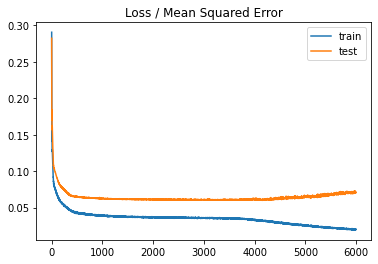

INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest/assets


In [14]:
def train_lstm(X_train, y_train, X_test, y_test, lstm_units, dropout_prob, epochs, batch_size):
    # We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (y_train.shape[0], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))

    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True,
                input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_prob))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units,
                return_sequences=True))
    model.add(Dropout(dropout_prob))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    # Adding the output layer
    model.add(Dense(units=1))

    # Adam optimizer
    opt = Adam(learning_rate=0.0005, epsilon=1e-06, decay=1e-06)
    # # PiecewiseConstantDecay optimizer
    # boundaries = [200, 800, 2000, 4000]
    # values = [0.01, 0.001, 0.0005, 0.0001, 0.00001]
    # opt = keras.optimizers.schedules.PiecewiseConstantDecay(
    #     boundaries, values)

    checkpoint = ModelCheckpoint("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss", monitor='val_loss', verbose=2,
                                 save_best_only=True, mode='auto')

    # Compiling the RNN
    # model.compile(optimizer = opt, loss = 'mean_squared_error')
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=epochs, batch_size=batch_size,
                        callbacks=[checkpoint])

    # evaluate the model
    train_mse = model.evaluate(X_train, y_train)
    test_mse = model.evaluate(X_test, y_test)
    print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
    # plot loss during training
    plt.title('Loss / Mean Squared Error')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()

    return model

model = train_lstm(X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, lstm_units, dropout_prob, epochs, batch_size)
model.save('/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_latest')

### Test model

In [15]:
def get_direction(pre, cur, min_change=1):
    if abs(pre - cur) < min_change:
        return 0
    else:
        if pre < cur:
            return 1
        else:
            return -1

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

def calc_confusion_matrix(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    cm = confusion_matrix(y_true_direction, y_pred_direction, labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[-1, 0, 1])
    disp.plot()
    return cm

def calc_accuracy(X, y_true, y_pred, min_change=1):
    assert len(X) == len(y_true)
    assert len(X) == len(y_pred)
    n = len(y_true)
    y_true_direction = [get_direction(X[i][-1], y_true[i], min_change) for i in range(n)]
    y_pred_direction = [get_direction(X[i][-1], y_pred[i], min_change) for i in range(n)]
    return accuracy_score(y_true_direction, y_pred_direction)

In [17]:
# X_test = X_train
lstm_model = keras.models.load_model("/content/drive/MyDrive/PredictPriceByPattern/LSTM_double_top_best_val_loss")

In [18]:
#@title Define some params for make decision { run: "auto" }
min_price_change = 0 #@param {type:"number"}


In [19]:
predicted_stock_price = lstm_model.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1)))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [20]:
y_test, predicted_stock_price

(array([[2.21449997e+02],
        [2.34036000e+05],
        [4.50000000e+02],
        ...,
        [3.36000000e+03],
        [8.31600037e+01],
        [2.65320007e+02]]), array([[2.1866174e+02],
        [2.2922828e+05],
        [4.3241370e+02],
        ...,
        [3.2440747e+03],
        [8.8053711e+01],
        [2.5257422e+02]], dtype=float32))

In [21]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[2.79]
 [4807.72]
 [17.59]
 ...
 [115.93]
 [-4.89]
 [12.75]]
[258923.75]


rmse: 8845.364360590913 mape: 2.8394236271609867
confusion_matrix: [[244   0 295]
 [  0   0   0]
 [255   0 336]]
acc: 0.5132743362831859


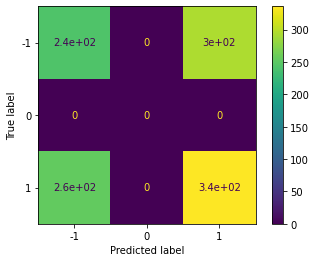

In [22]:
# Calculate RMSE and MAPE
from sklearn.metrics import mean_squared_error

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

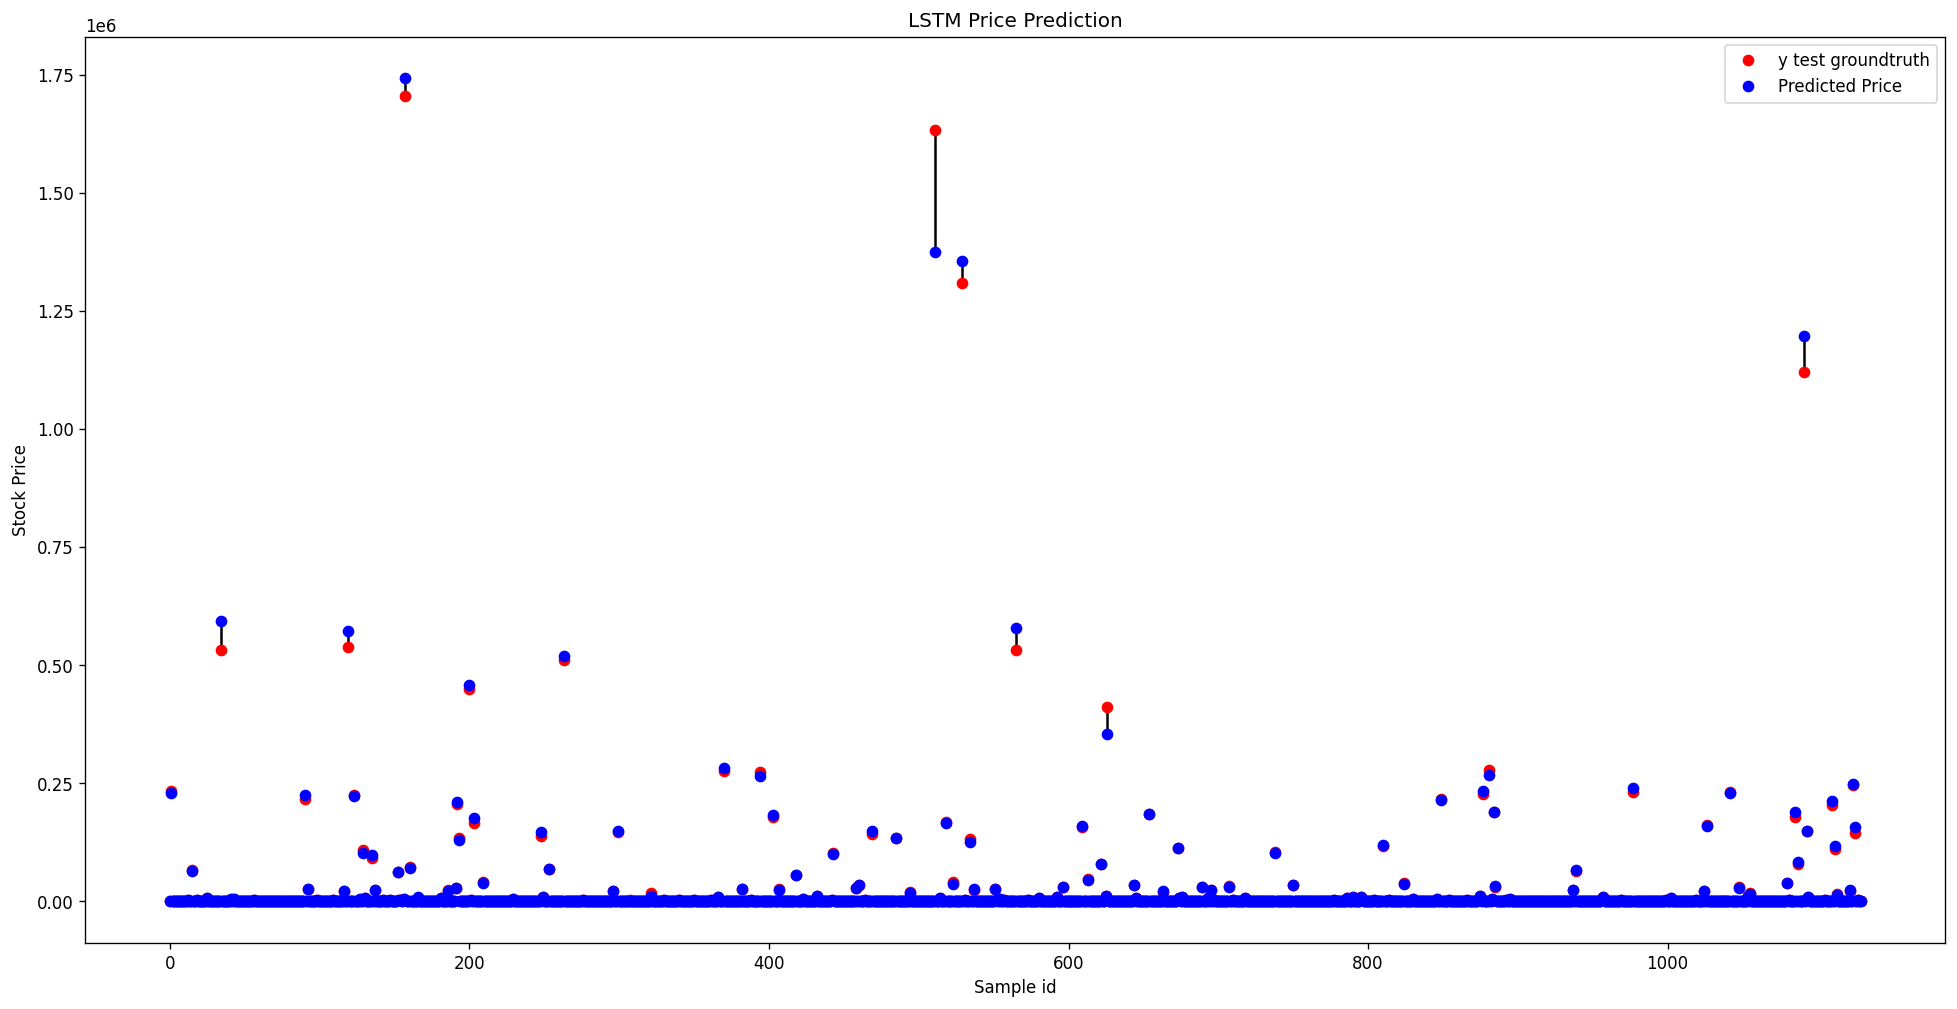

In [23]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('LSTM Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## XGBoost model

### Build model

In [24]:
#@title Build model
seed = 100 #@param {type:"integer"}
n_estimators = 100 #@param {type:"integer"}
max_depth = 3 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
min_child_weight = 0 #@param {type:"number"}
subsample = 1 #@param {type:"number"}
colsample_bytree = 1 #@param {type:"number"}
colsample_bylevel = 1 #@param {type:"number"}
gamma = 0 #@param {type:"number"}
from xgboost import XGBRegressor

xgbmodel = XGBRegressor(seed=seed,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        colsample_bylevel=colsample_bylevel,
                        gamma=gamma)

### Train the model

In [25]:
xgbmodel.fit(np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1])), np.reshape(y_train_scaled, (y_train_scaled.shape[0])))

[17:05:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
             silent=None, subsample=1, verbosity=1)

### Test model

In [26]:
predicted_stock_price = xgbmodel.predict(np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1])))
predicted_stock_price = np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1))
if scale_method == 'MinMax':
    predicted_stock_price = sc_test.inverse_transform(predicted_stock_price.T).T
    # y_test = sc_test.inverse_transform(y_test.T).T

In [27]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
print(y_test - predicted_stock_price)
print(max(abs(y_test - predicted_stock_price)))

[[0.77]
 [5846.52]
 [34.74]
 ...
 [87.01]
 [-6.27]
 [15.87]]
[218880.88]


rmse: 7554.226495617278 mape: 2.7123674667365156
confusion_matrix: [[226   0 313]
 [  0   0   0]
 [269   0 322]]
acc: 0.4849557522123894


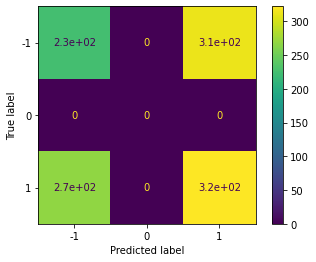

In [28]:
rmse = math.sqrt(mean_squared_error(y_test, predicted_stock_price))
mape = get_mape(y_test, predicted_stock_price)
conf_matrix = calc_confusion_matrix(X_test, y_test, predicted_stock_price, min_price_change)
acc = calc_accuracy(X_test, y_test, predicted_stock_price, min_price_change)

print('rmse:', rmse, 'mape:', mape)
print('confusion_matrix:', conf_matrix)
print('acc:', acc)

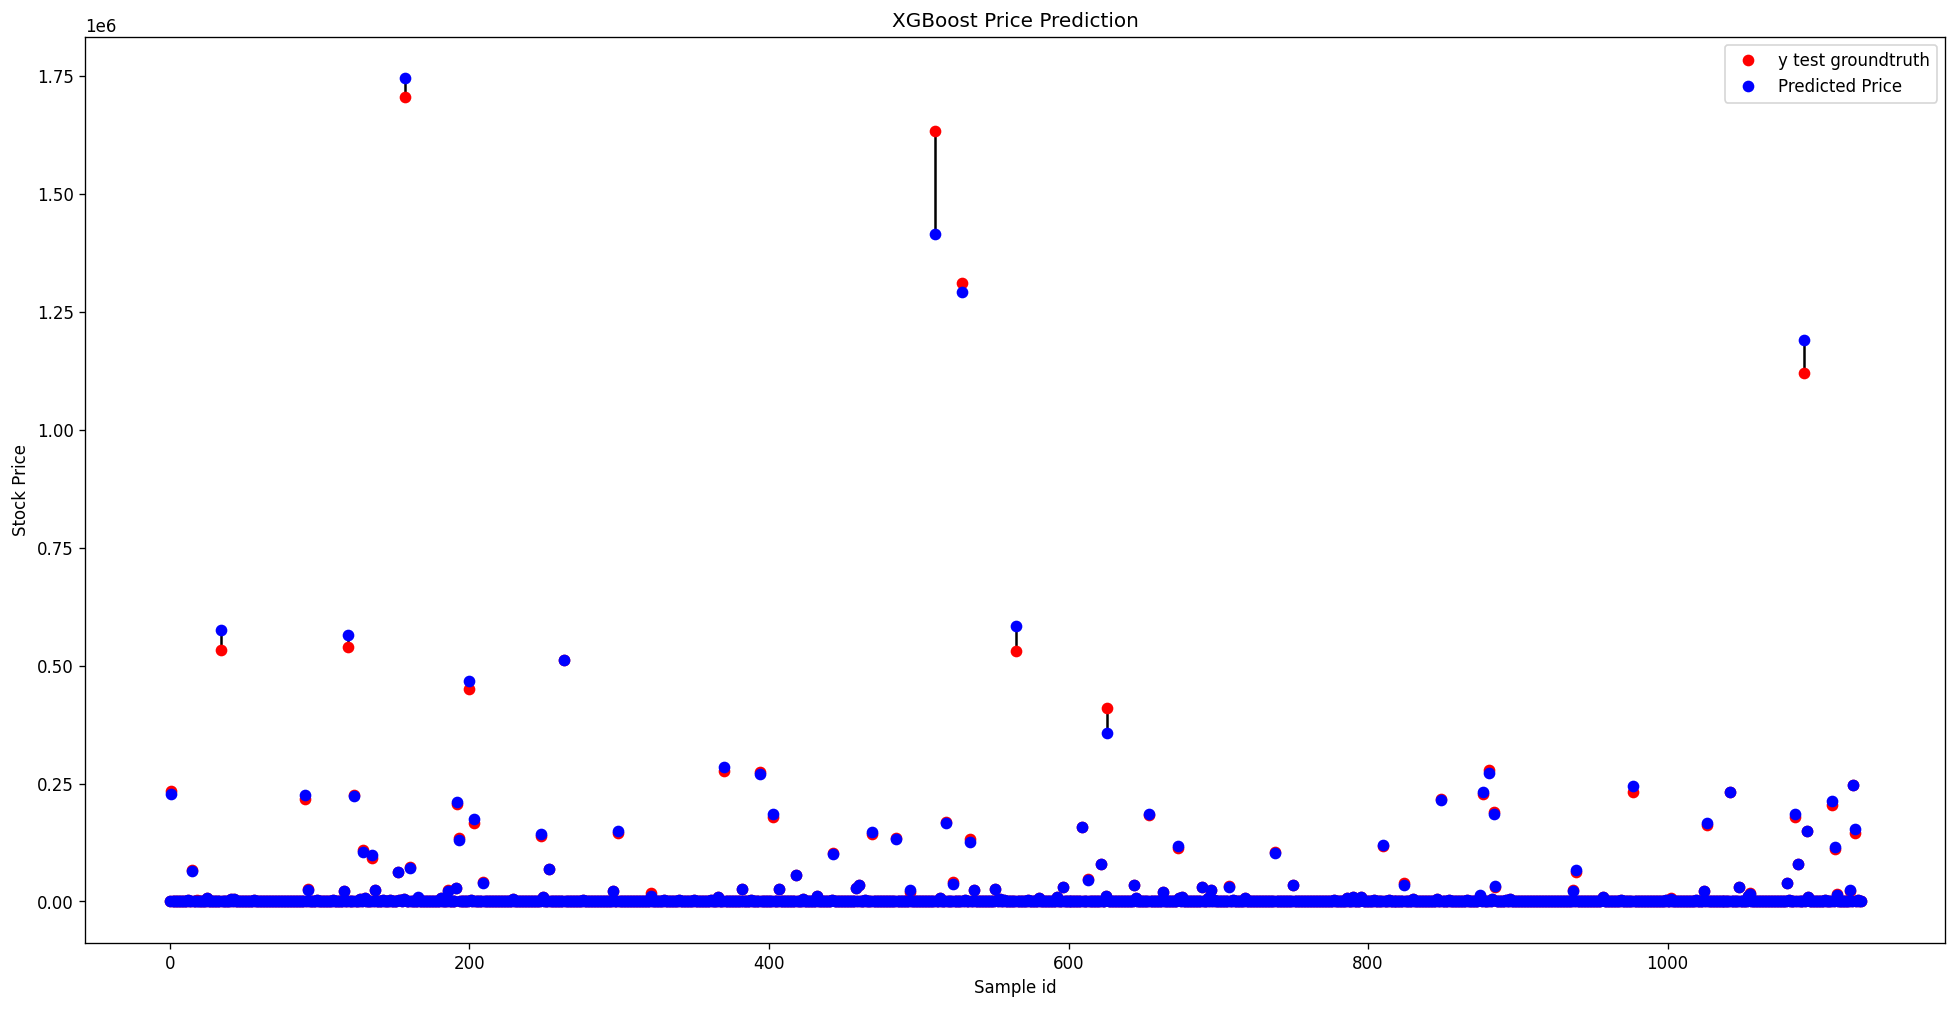

In [29]:
# Visualising the results
plt.figure(figsize=(20, 10), dpi= 120, facecolor='w', edgecolor='k')
plt.plot(range(len(y_test)), y_test, 'o', color = 'red', label = 'y test groundtruth')
plt.plot(range(len(y_test)), predicted_stock_price, 'o', color = 'blue', label = 'Predicted Price')
plt.vlines(range(len(y_test)), np.minimum(y_test, predicted_stock_price), np.maximum(y_test, predicted_stock_price))
# plt.xticks(np.arange(0,459,50))
plt.title('XGBoost Price Prediction')
plt.xlabel('Sample id')
plt.ylabel('Stock Price')
plt.legend()
plt.show()